In [243]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
## Seeding 
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = float
SEG_DTYPE = np.uint8

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall, Precision


<Figure size 640x480 with 0 Axes>

In [244]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [245]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [246]:
def imshow(*args,**kwargs):
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def dice(im1, im2):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [247]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [248]:
image_size =  256
train_path = "train"
batch_size = 8
epochs = 100
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

2259


In [249]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """    
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)
    img_slc = normalize_image(img_slc)

    
    img_slc = img_slc * 255
    img_slc = img_slc.astype('uint8')
    img_slc = cv2.equalizeHist(img_slc)
    img_slc = normalize_image(img_slc)
    return img_slc


In [252]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(70)
print(x.shape,y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


0


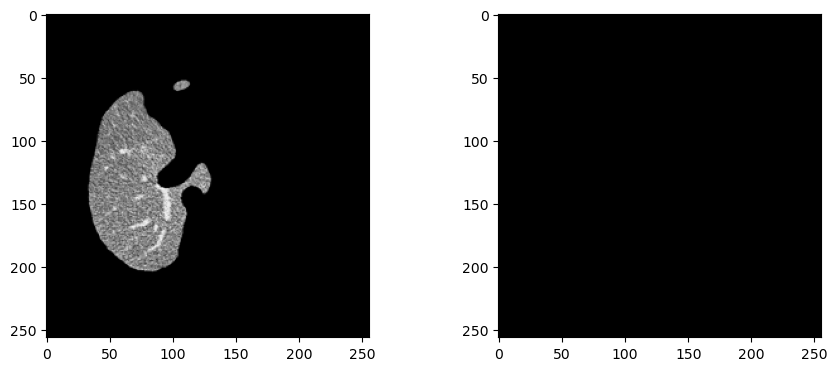

In [253]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [254]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c

In [255]:
def ResUNet():
    f = [32, 64, 128, 256, 512]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [256]:
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv


def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.image.resize(upsample_psi, (shape_x[1], shape_x[2]))  # Resize upsample_psi
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (256,256,3), drop_rate = 0.25, lr=0.00001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

#     model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
      model.load_weights(trained_weights)

    return model

In [257]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = y_true_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou(y_true,y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [258]:
model = ResUNet()
adam = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["acc", dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_375 (Conv2D)         (None, 256, 256, 32)         896       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_252 (B  (None, 256, 256, 32)         128       ['conv2d_375[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_316 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_2

 atchNormalization)                                                                               
                                                                                                  
 conv2d_386 (Conv2D)         (None, 32, 32, 256)          33024     ['add_103[0][0]']             
                                                                                                  
 activation_322 (Activation  (None, 32, 32, 256)          0         ['batch_normalization_261[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_262 (B  (None, 32, 32, 256)          1024      ['conv2d_386[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_38

                                                                                                  
 add_106 (Add)               (None, 32, 32, 512)          0         ['batch_normalization_270[0][0
                                                                    ]',                           
                                                                     'conv2d_393[0][0]']          
                                                                                                  
 up_sampling2d_57 (UpSampli  (None, 64, 64, 512)          0         ['add_106[0][0]']             
 ng2D)                                                                                            
                                                                                                  
 concatenate_62 (Concatenat  (None, 64, 64, 640)          0         ['up_sampling2d_57[0][0]',    
 e)                                                                  'add_103[0][0]']             
          

                                                                                                  
 conv2d_403 (Conv2D)         (None, 256, 256, 64)         10304     ['concatenate_64[0][0]']      
                                                                                                  
 activation_334 (Activation  (None, 256, 256, 64)         0         ['batch_normalization_278[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_279 (B  (None, 256, 256, 64)         256       ['conv2d_403[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_402 (Conv2D)         (None, 256, 256, 64)         36928     ['activation_334[0][0]']      
          

In [259]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size


logger_path = os.path.join("No-Augmentation-Liver-tumor-segmentation.csv")
path_ = "Dataset"

callbacks = [
    ModelCheckpoint(path_, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-7,verbose=1),
    CSVLogger(logger_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=False)
]

model_history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, shuffle=True, callbacks=callbacks)

Epoch 1/100
282/282 [==============================] - ETA: 0s - loss: 0.0162 - acc: 0.9947 - dice_coef: 0.0480 - iou: 0.0130 - recall_1: 1.9907e-05 - precision_1: 9.9812e-06 
Epoch 1: val_loss improved from inf to 0.00765, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 6446s 23s/step - loss: 0.0162 - acc: 0.9947 - dice_coef: 0.0480 - iou: 0.0130 - recall_1: 1.9907e-05 - precision_1: 9.9812e-06 - val_loss: 0.0077 - val_acc: 0.9985 - val_dice_coef: 0.0621 - val_iou: 0.0119 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 2/100
282/282 [==============================] - ETA: 0s - loss: 0.0084 - acc: 0.9982 - dice_coef: 0.0394 - iou: 0.0107 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00
Epoch 2: val_loss improved from 0.00765 to 0.00575, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 691s 2s/step - loss: 0.0084 - acc: 0.9982 - dice_coef: 0.0394 - iou: 0.0107 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0058 - val_acc: 0.9988 - val_dice_coef: 0.0535 - val_iou: 0.0117 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 3/100
282/282 [==============================] - ETA: 0s - loss: 0.0074 - acc: 0.9984 - dice_coef: 0.0396 - iou: 0.0102 - recall_1: 0.0012 - precision_1: 0.0465
Epoch 3: val_loss improved from 0.00575 to 0.00518, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 692s 2s/step - loss: 0.0074 - acc: 0.9984 - dice_coef: 0.0396 - iou: 0.0102 - recall_1: 0.0012 - precision_1: 0.0465 - val_loss: 0.0052 - val_acc: 0.9988 - val_dice_coef: 0.0322 - val_iou: 0.0095 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 4/100
282/282 [==============================] - ETA: 0s - loss: 0.0072 - acc: 0.9984 - dice_coef: 0.0400 - iou: 0.0100 - recall_1: 2.2991e-05 - precision_1: 0.1333
Epoch 4: val_loss did not improve from 0.00518
282/282 [==============================] - 688s 2s/step - loss: 0.0072 - acc: 0.9984 - dice_coef: 0.0400 - iou: 0.0100 - recall_1: 2.2991e-05 - precision_1: 0.1333 - val_loss: 0.0061 - val_acc: 0.9988 - val_dice_coef: 0.0574 - val_iou: 0.0110 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 5/100
282/282 [==============================] - ETA: 0s - loss: 0.0074 - acc: 0.9983 - dice_coef: 0.0462 - iou: 0.0138 - recall_1: 0.0021 - precision_1: 

INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 694s 2s/step - loss: 0.0071 - acc: 0.9983 - dice_coef: 0.0830 - iou: 0.0286 - recall_1: 0.1019 - precision_1: 0.5961 - val_loss: 0.0044 - val_acc: 0.9989 - val_dice_coef: 0.0515 - val_iou: 0.0247 - val_recall_1: 0.0456 - val_precision_1: 0.5784 - lr: 0.0010
Epoch 10/100
282/282 [==============================] - ETA: 0s - loss: 0.0059 - acc: 0.9985 - dice_coef: 0.0773 - iou: 0.0322 - recall_1: 0.1492 - precision_1: 0.7086
Epoch 10: val_loss did not improve from 0.00436
282/282 [==============================] - 692s 2s/step - loss: 0.0059 - acc: 0.9985 - dice_coef: 0.0773 - iou: 0.0322 - recall_1: 0.1492 - precision_1: 0.7086 - val_loss: 0.0054 - val_acc: 0.9988 - val_dice_coef: 0.0363 - val_iou: 0.0079 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 11/100
282/282 [==============================] - ETA: 0s - loss: 0.0071 - acc: 0.9982 - dice_coef: 0.1004 - iou: 0.0417 - recall_1: 0.1143 - precision_1: 0.5885
Epoch 

INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 706s 3s/step - loss: 0.0053 - acc: 0.9985 - dice_coef: 0.1520 - iou: 0.0698 - recall_1: 0.2463 - precision_1: 0.7066 - val_loss: 0.0040 - val_acc: 0.9989 - val_dice_coef: 0.0605 - val_iou: 0.0317 - val_recall_1: 0.0656 - val_precision_1: 0.7450 - lr: 0.0010
Epoch 16/100
282/282 [==============================] - ETA: 0s - loss: 0.0062 - acc: 0.9983 - dice_coef: 0.1170 - iou: 0.0475 - recall_1: 0.1309 - precision_1: 0.5751
Epoch 16: val_loss improved from 0.00399 to 0.00383, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 707s 3s/step - loss: 0.0062 - acc: 0.9983 - dice_coef: 0.1170 - iou: 0.0475 - recall_1: 0.1309 - precision_1: 0.5751 - val_loss: 0.0038 - val_acc: 0.9990 - val_dice_coef: 0.0749 - val_iou: 0.0413 - val_recall_1: 0.1569 - val_precision_1: 0.7409 - lr: 0.0010
Epoch 17/100
282/282 [==============================] - ETA: 0s - loss: 0.0050 - acc: 0.9986 - dice_coef: 0.1314 - iou: 0.0602 - recall_1: 0.2285 - precision_1: 0.6676
Epoch 17: val_loss did not improve from 0.00383
282/282 [==============================] - 709s 3s/step - loss: 0.0050 - acc: 0.9986 - dice_coef: 0.1314 - iou: 0.0602 - recall_1: 0.2285 - precision_1: 0.6676 - val_loss: 0.0039 - val_acc: 0.9991 - val_dice_coef: 0.1099 - val_iou: 0.0493 - val_recall_1: 0.2681 - val_precision_1: 0.7870 - lr: 0.0010
Epoch 18/100
282/282 [==============================] - ETA: 0s - loss: 0.0053 - acc: 0.9985 - dice_coef: 0.1962 - iou: 0.0901 - recall_1: 0.2835 - precision_1: 0.7273
Epoch 18: val_

INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 722s 3s/step - loss: 0.0022 - acc: 0.9993 - dice_coef: 0.2497 - iou: 0.1476 - recall_1: 0.6591 - precision_1: 0.8384 - val_loss: 0.0023 - val_acc: 0.9991 - val_dice_coef: 0.2490 - val_iou: 0.1294 - val_recall_1: 0.7522 - val_precision_1: 0.5792 - lr: 1.0000e-04
Epoch 28/100
282/282 [==============================] - ETA: 0s - loss: 0.0019 - acc: 0.9994 - dice_coef: 0.2992 - iou: 0.1928 - recall_1: 0.7776 - precision_1: 0.8566
Epoch 28: val_loss improved from 0.00231 to 0.00226, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 712s 3s/step - loss: 0.0019 - acc: 0.9994 - dice_coef: 0.2992 - iou: 0.1928 - recall_1: 0.7776 - precision_1: 0.8566 - val_loss: 0.0023 - val_acc: 0.9991 - val_dice_coef: 0.2609 - val_iou: 0.1365 - val_recall_1: 0.7541 - val_precision_1: 0.5756 - lr: 1.0000e-04
Epoch 29/100
282/282 [==============================] - ETA: 0s - loss: 0.0017 - acc: 0.9994 - dice_coef: 0.2976 - iou: 0.1902 - recall_1: 0.7683 - precision_1: 0.8668
Epoch 29: val_loss did not improve from 0.00226
282/282 [==============================] - 709s 3s/step - loss: 0.0017 - acc: 0.9994 - dice_coef: 0.2976 - iou: 0.1902 - recall_1: 0.7683 - precision_1: 0.8668 - val_loss: 0.0047 - val_acc: 0.9981 - val_dice_coef: 0.3675 - val_iou: 0.1043 - val_recall_1: 0.8366 - val_precision_1: 0.3680 - lr: 1.0000e-04
Epoch 30/100
282/282 [==============================] - ETA: 0s - loss: 0.0016 - acc: 0.9994 - dice_coef: 0.3320 - iou: 0.2154 - recall_1: 0.7988 - precision_1: 0.8673
Epoch 

INFO:tensorflow:Assets written to: Dataset/assets


282/282 [==============================] - 691s 2s/step - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3438 - iou: 0.2431 - recall_1: 0.8547 - precision_1: 0.9033 - val_loss: 0.0021 - val_acc: 0.9992 - val_dice_coef: 0.3393 - val_iou: 0.1842 - val_recall_1: 0.8474 - val_precision_1: 0.6224 - lr: 1.0000e-05
Epoch 42/100
282/282 [==============================] - ETA: 0s - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3407 - iou: 0.2417 - recall_1: 0.8542 - precision_1: 0.8980
Epoch 42: val_loss did not improve from 0.00214
282/282 [==============================] - 689s 2s/step - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3407 - iou: 0.2417 - recall_1: 0.8542 - precision_1: 0.8980 - val_loss: 0.0021 - val_acc: 0.9992 - val_dice_coef: 0.3394 - val_iou: 0.1838 - val_recall_1: 0.8448 - val_precision_1: 0.6232 - lr: 1.0000e-05
Epoch 43/100
282/282 [==============================] - ETA: 0s - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3540 - iou: 0.2548 - recall_1: 0.8522 - precision_1: 0.9085
Epoch 

Epoch 57/100
282/282 [==============================] - ETA: 0s - loss: 0.0011 - acc: 0.9996 - dice_coef: 0.3590 - iou: 0.2633 - recall_1: 0.8796 - precision_1: 0.9105
Epoch 57: val_loss did not improve from 0.00214
282/282 [==============================] - 687s 2s/step - loss: 0.0011 - acc: 0.9996 - dice_coef: 0.3590 - iou: 0.2633 - recall_1: 0.8796 - precision_1: 0.9105 - val_loss: 0.0024 - val_acc: 0.9991 - val_dice_coef: 0.3566 - val_iou: 0.1856 - val_recall_1: 0.8645 - val_precision_1: 0.5880 - lr: 1.0000e-06
Epoch 58/100
282/282 [==============================] - ETA: 0s - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3675 - iou: 0.2664 - recall_1: 0.8705 - precision_1: 0.9151
Epoch 58: val_loss did not improve from 0.00214
282/282 [==============================] - 689s 2s/step - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3675 - iou: 0.2664 - recall_1: 0.8705 - precision_1: 0.9151 - val_loss: 0.0027 - val_acc: 0.9990 - val_dice_coef: 0.3631 - val_iou: 0.1825 - val_recall_1: 0.8806 -

INFO:tensorflow:Assets written to: Dataset/assets



Epoch 71: ReduceLROnPlateau reducing learning rate to 1e-07.
282/282 [==============================] - 694s 2s/step - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3649 - iou: 0.2581 - recall_1: 0.8594 - precision_1: 0.9060 - val_loss: 0.0021 - val_acc: 0.9992 - val_dice_coef: 0.3540 - val_iou: 0.1900 - val_recall_1: 0.8583 - val_precision_1: 0.6256 - lr: 1.0000e-07
Epoch 72/100
282/282 [==============================] - ETA: 0s - loss: 0.0013 - acc: 0.9995 - dice_coef: 0.3592 - iou: 0.2566 - recall_1: 0.8670 - precision_1: 0.8997
Epoch 72: val_loss did not improve from 0.00209
282/282 [==============================] - 688s 2s/step - loss: 0.0013 - acc: 0.9995 - dice_coef: 0.3592 - iou: 0.2566 - recall_1: 0.8670 - precision_1: 0.8997 - val_loss: 0.0024 - val_acc: 0.9991 - val_dice_coef: 0.3596 - val_iou: 0.1854 - val_recall_1: 0.8717 - val_precision_1: 0.5840 - lr: 1.0000e-07
Epoch 73/100
282/282 [==============================] - ETA: 0s - loss: 0.0011 - acc: 0.9996 - dice_coef: 0.3571

282/282 [==============================] - ETA: 0s - loss: 0.0011 - acc: 0.9996 - dice_coef: 0.3412 - iou: 0.2474 - recall_1: 0.8703 - precision_1: 0.9181
Epoch 87: val_loss did not improve from 0.00209
282/282 [==============================] - 687s 2s/step - loss: 0.0011 - acc: 0.9996 - dice_coef: 0.3412 - iou: 0.2474 - recall_1: 0.8703 - precision_1: 0.9181 - val_loss: 0.0043 - val_acc: 0.9986 - val_dice_coef: 0.4007 - val_iou: 0.1589 - val_recall_1: 0.9198 - val_precision_1: 0.4446 - lr: 1.0000e-07
Epoch 88/100
282/282 [==============================] - ETA: 0s - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3620 - iou: 0.2645 - recall_1: 0.8691 - precision_1: 0.9132
Epoch 88: val_loss did not improve from 0.00209
282/282 [==============================] - 688s 2s/step - loss: 0.0012 - acc: 0.9996 - dice_coef: 0.3620 - iou: 0.2645 - recall_1: 0.8691 - precision_1: 0.9132 - val_loss: 0.0025 - val_acc: 0.9991 - val_dice_coef: 0.3630 - val_iou: 0.1849 - val_recall_1: 0.8803 - val_precisio

In [271]:
model.save('tumor_model_100epochs_no_aug.keras')  # creates a HDF5 file 'my_model.h5'
model.save_weights("tumor_weights_final_100epochs_no_aug.keras")
model.save(os.path.join('models','tumor_model_100epochs_no_aug.keras'))  
model = keras.models.load_model(os.path.join('models','tumor_model_100epochs_no_aug.keras'),compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
model.summary()

# del model

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_375 (Conv2D)         (None, 256, 256, 32)         896       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_252 (B  (None, 256, 256, 32)         128       ['conv2d_375[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_316 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_2

 atchNormalization)                                                                               
                                                                                                  
 conv2d_386 (Conv2D)         (None, 32, 32, 256)          33024     ['add_103[0][0]']             
                                                                                                  
 activation_322 (Activation  (None, 32, 32, 256)          0         ['batch_normalization_261[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_262 (B  (None, 32, 32, 256)          1024      ['conv2d_386[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_38

                                                                                                  
 add_106 (Add)               (None, 32, 32, 512)          0         ['batch_normalization_270[0][0
                                                                    ]',                           
                                                                     'conv2d_393[0][0]']          
                                                                                                  
 up_sampling2d_57 (UpSampli  (None, 64, 64, 512)          0         ['add_106[0][0]']             
 ng2D)                                                                                            
                                                                                                  
 concatenate_62 (Concatenat  (None, 64, 64, 640)          0         ['up_sampling2d_57[0][0]',    
 e)                                                                  'add_103[0][0]']             
          

                                                                                                  
 conv2d_403 (Conv2D)         (None, 256, 256, 64)         10304     ['concatenate_64[0][0]']      
                                                                                                  
 activation_334 (Activation  (None, 256, 256, 64)         0         ['batch_normalization_278[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_279 (B  (None, 256, 256, 64)         256       ['conv2d_403[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_402 (Conv2D)         (None, 256, 256, 64)         36928     ['activation_334[0][0]']      
          

1/1 [==============================] - 2s 2s/step


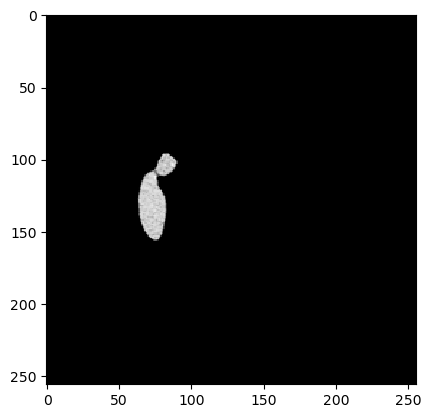

In [272]:
x, y = valid_gen.__getitem__(1)
result = model.predict(x)

result = result > 0.5

imshow(x[1])


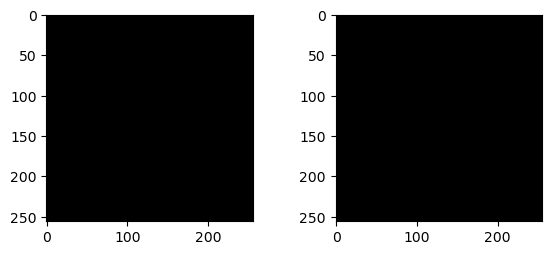

In [273]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

1/1 [==============================] - 2s 2s/step


/var/folders/w7/y5klds4x3_53168tgqlttv6w0000gn/T/ipykernel_30797/2402579901.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20,20))


1/1 [==============================] - 2s 2s/step


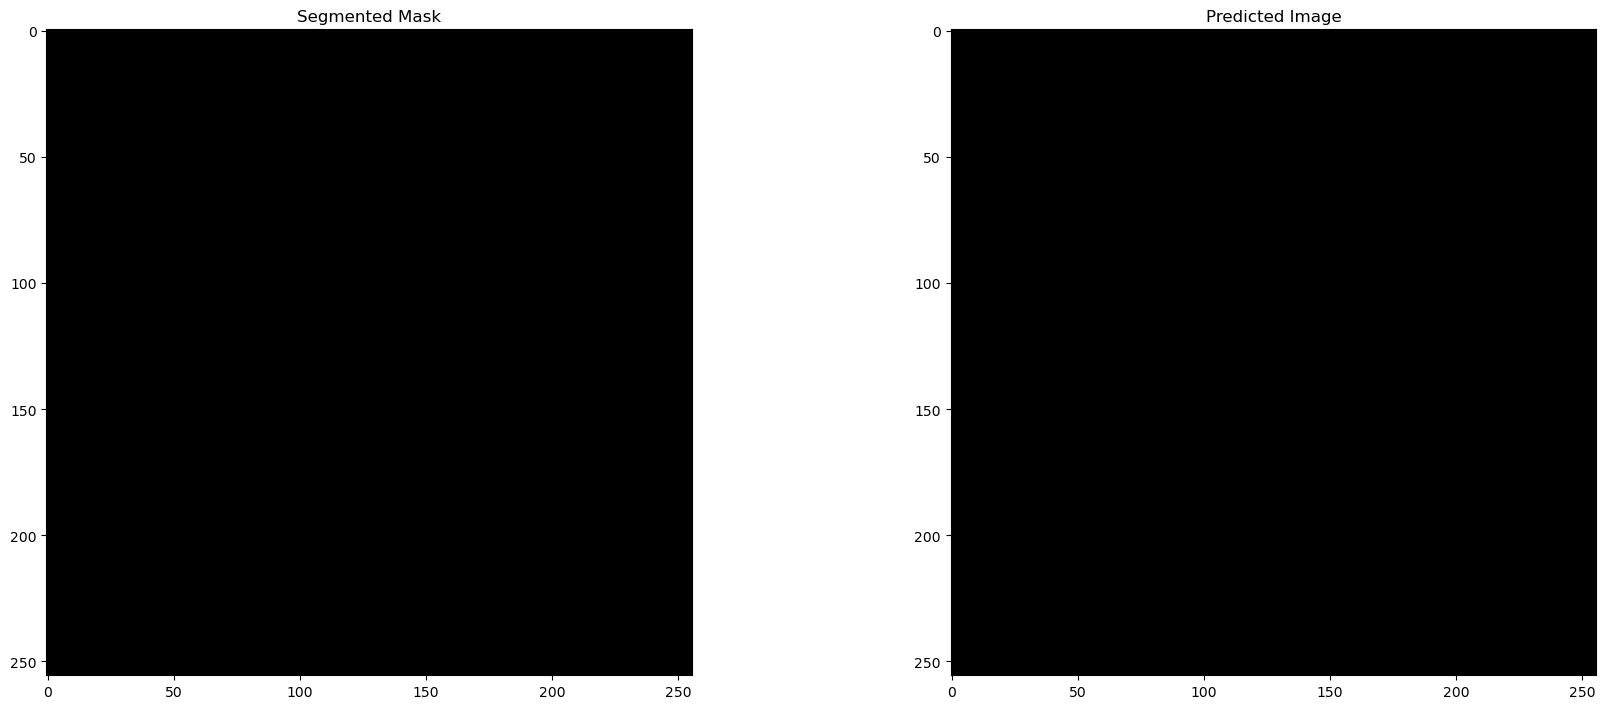

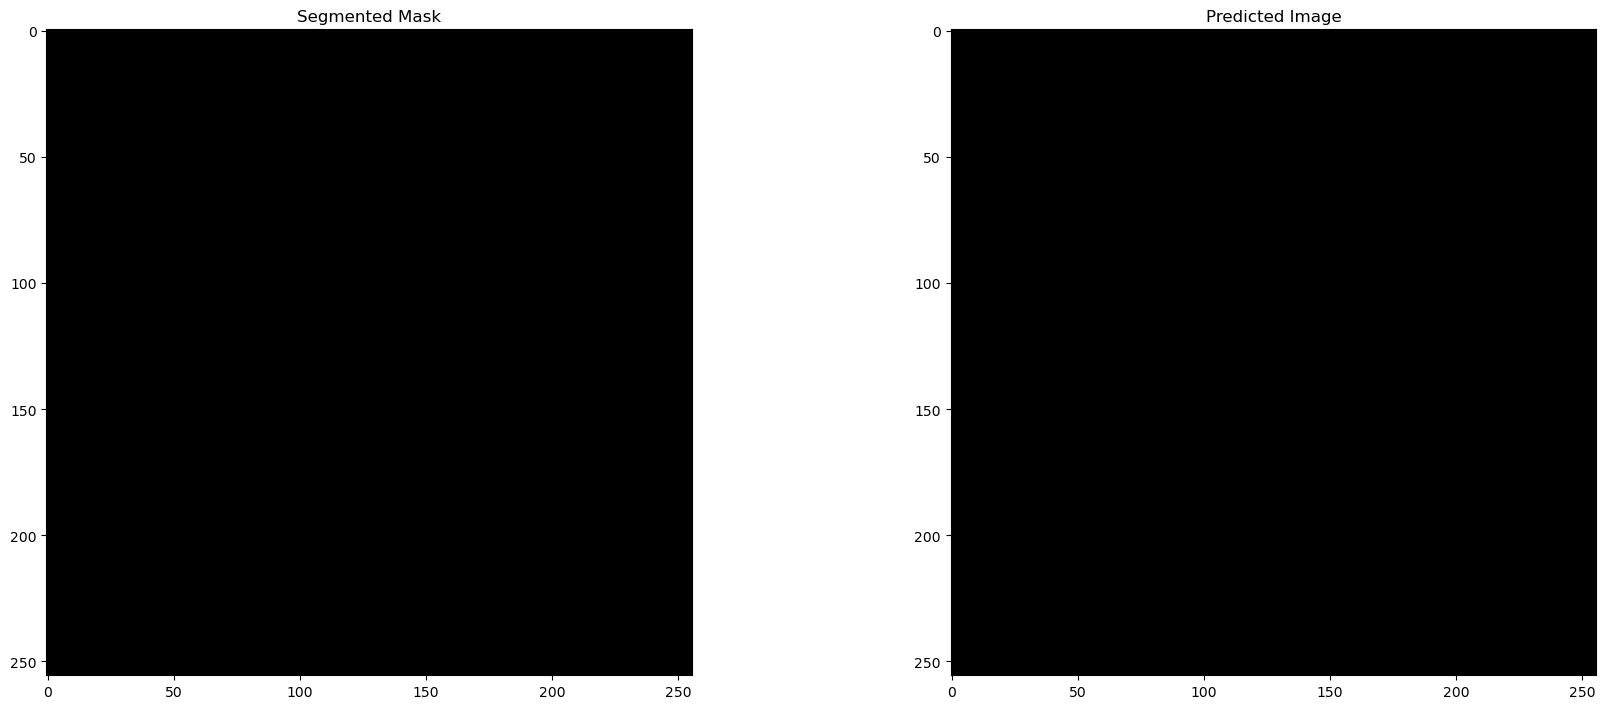

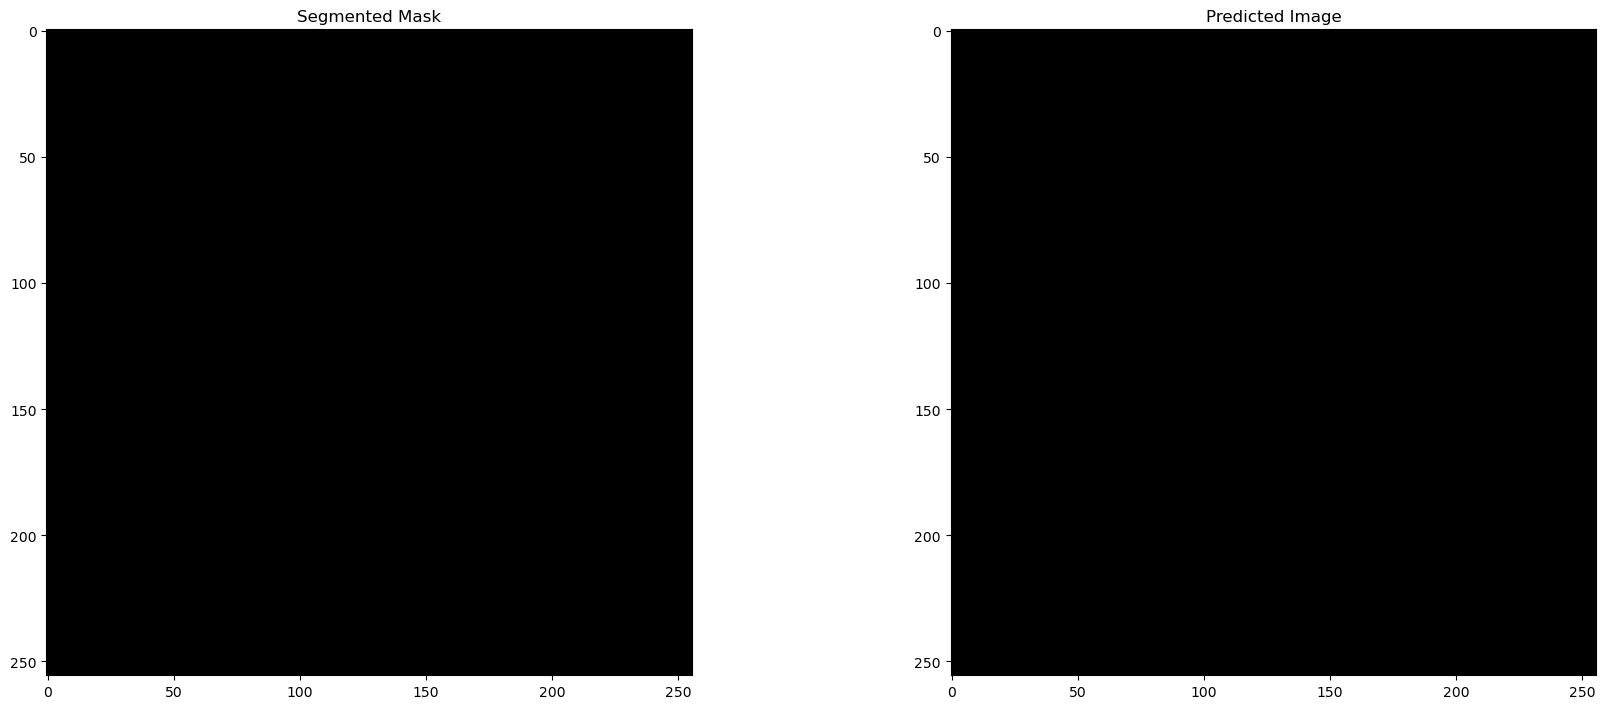

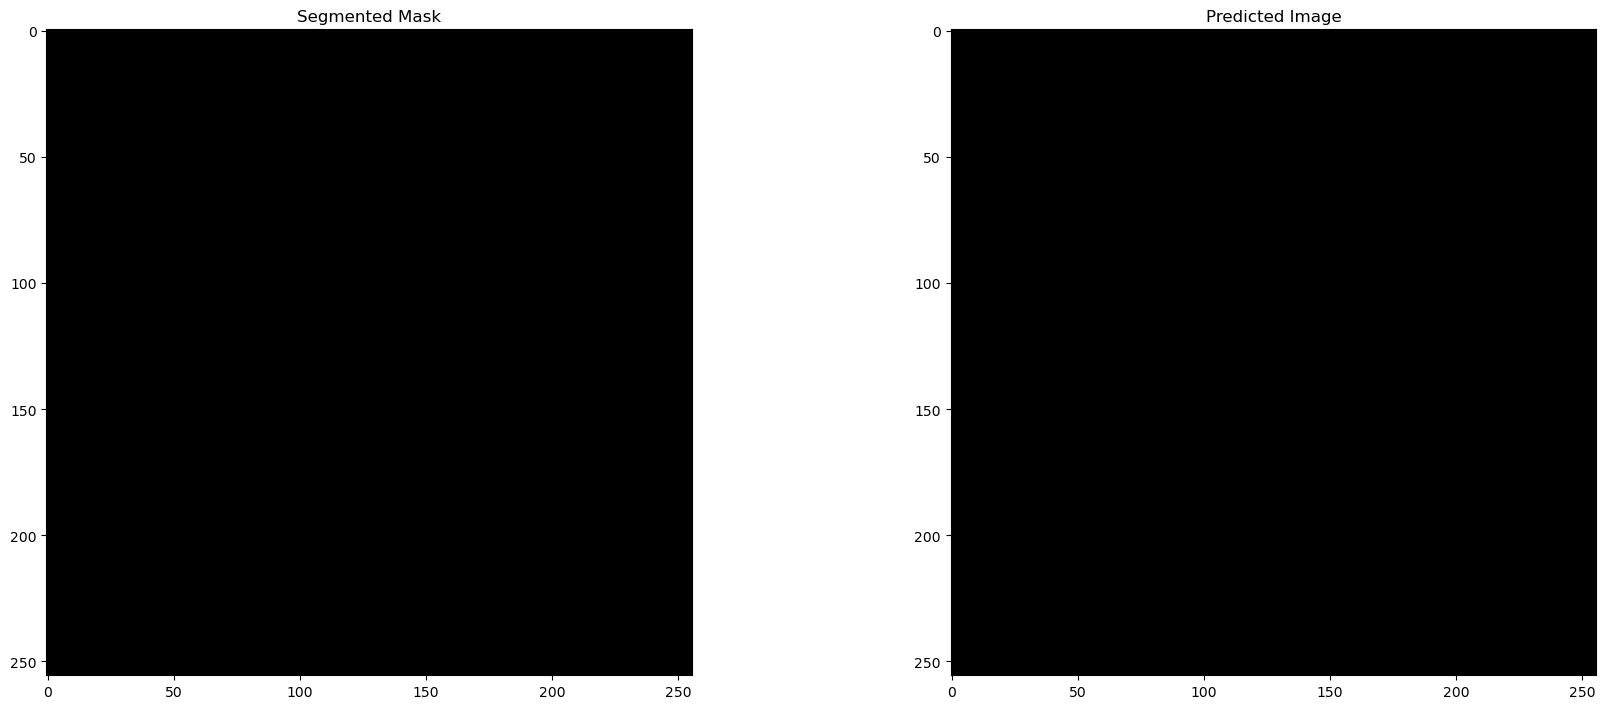

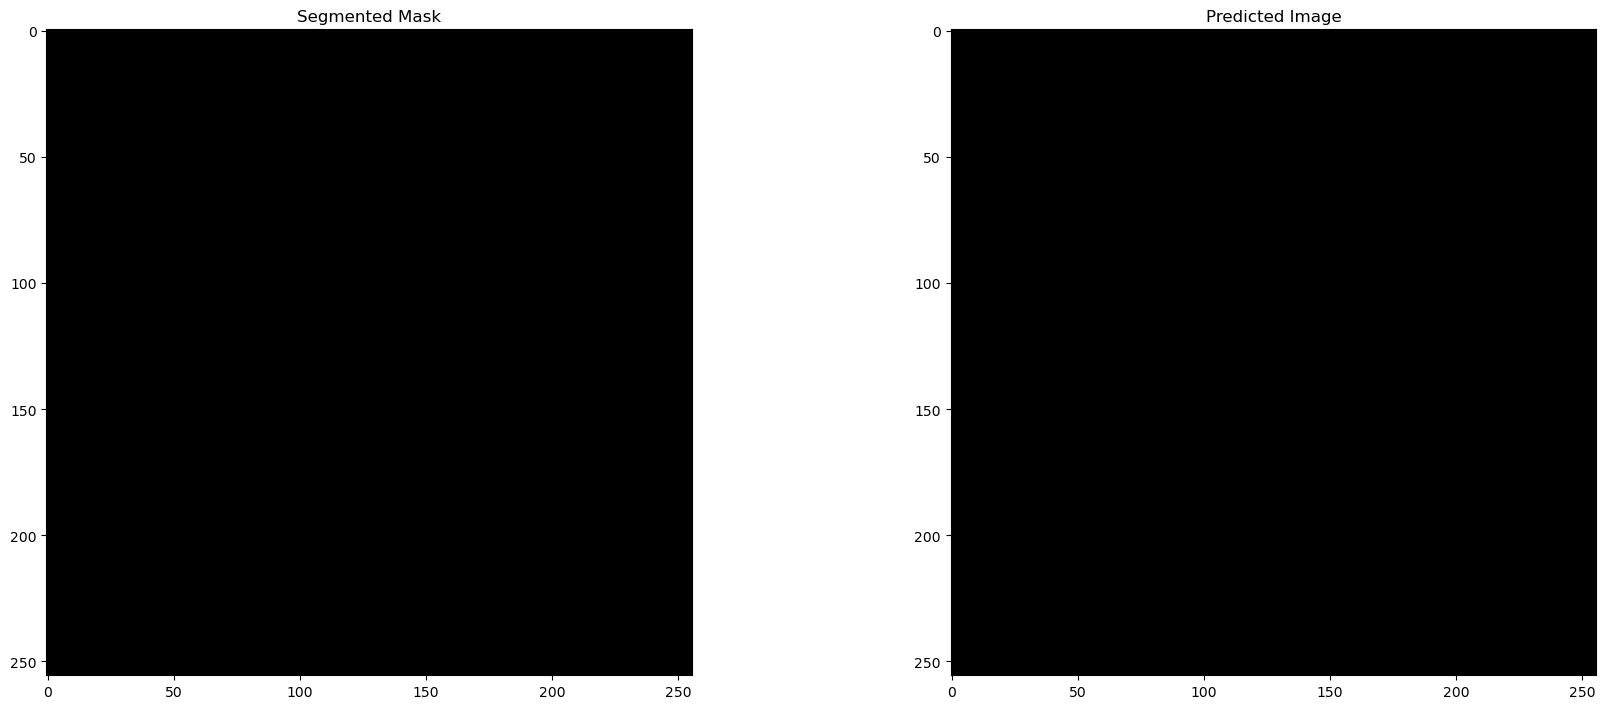

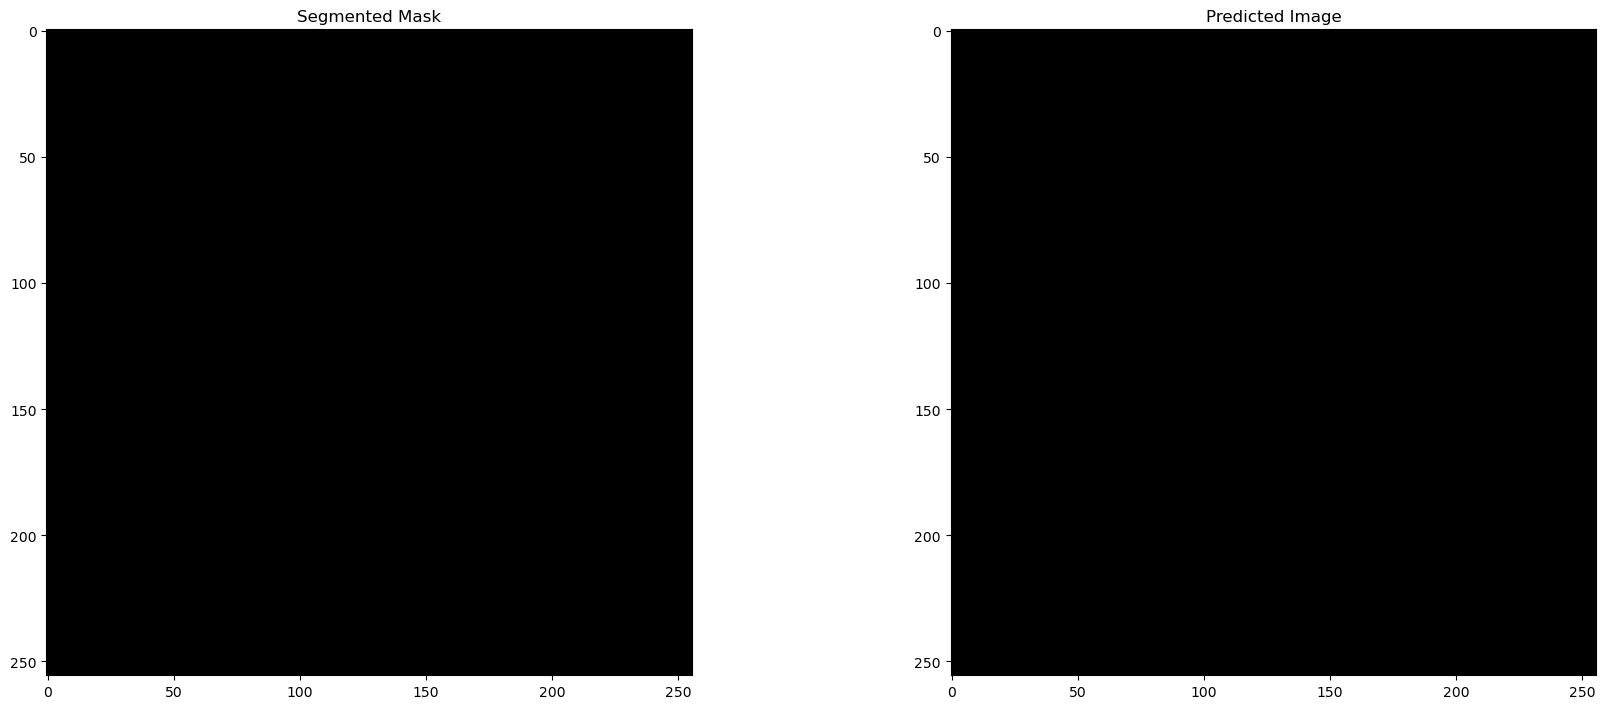

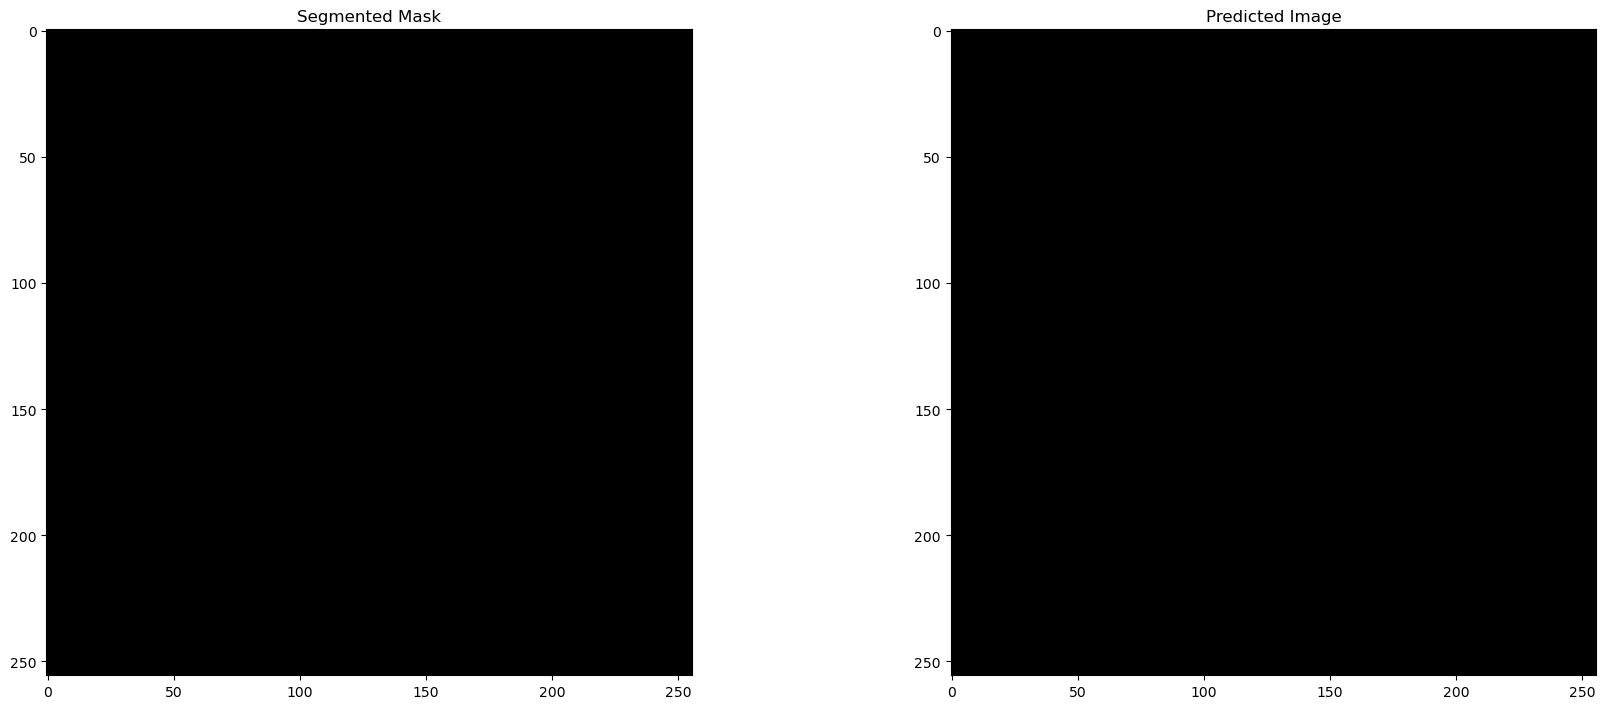

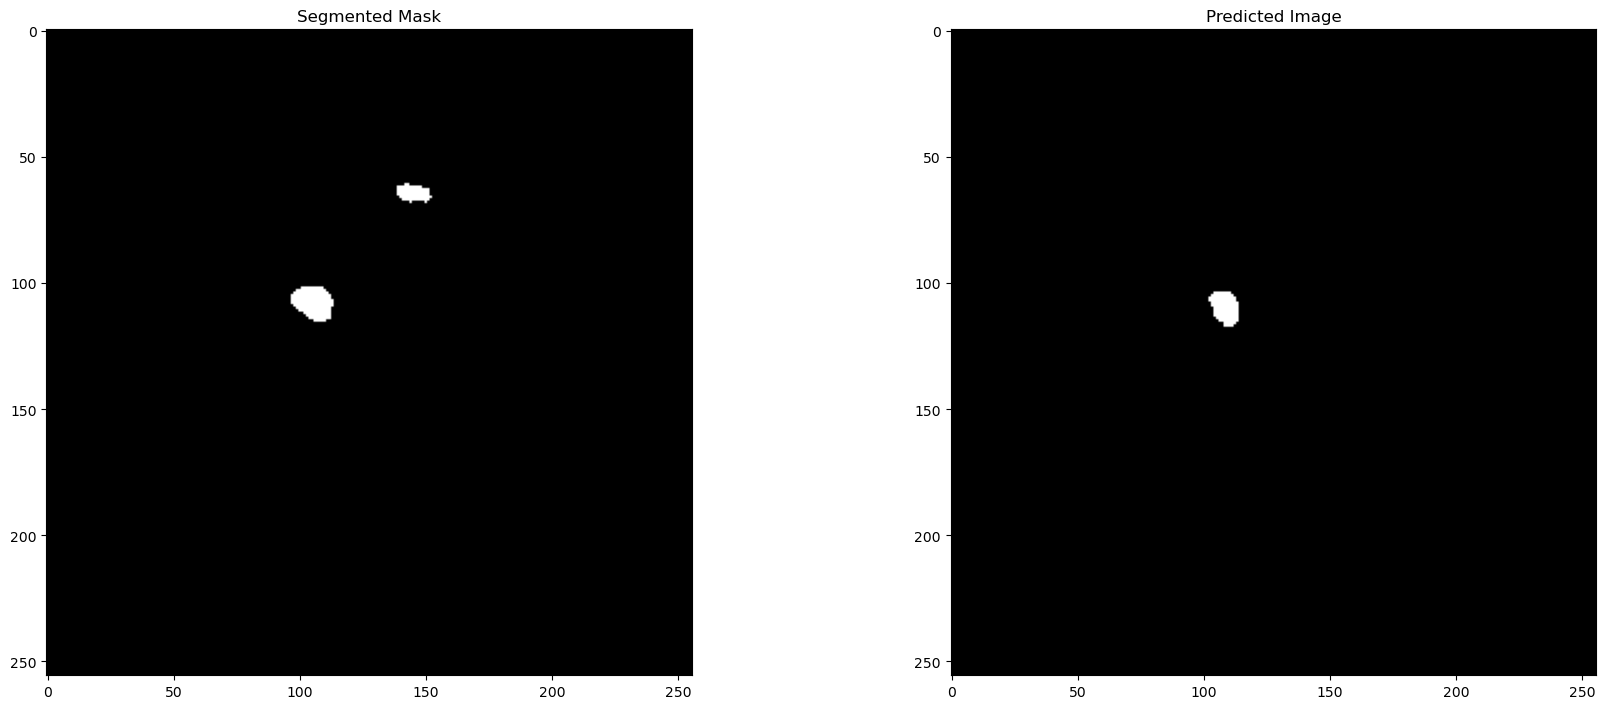

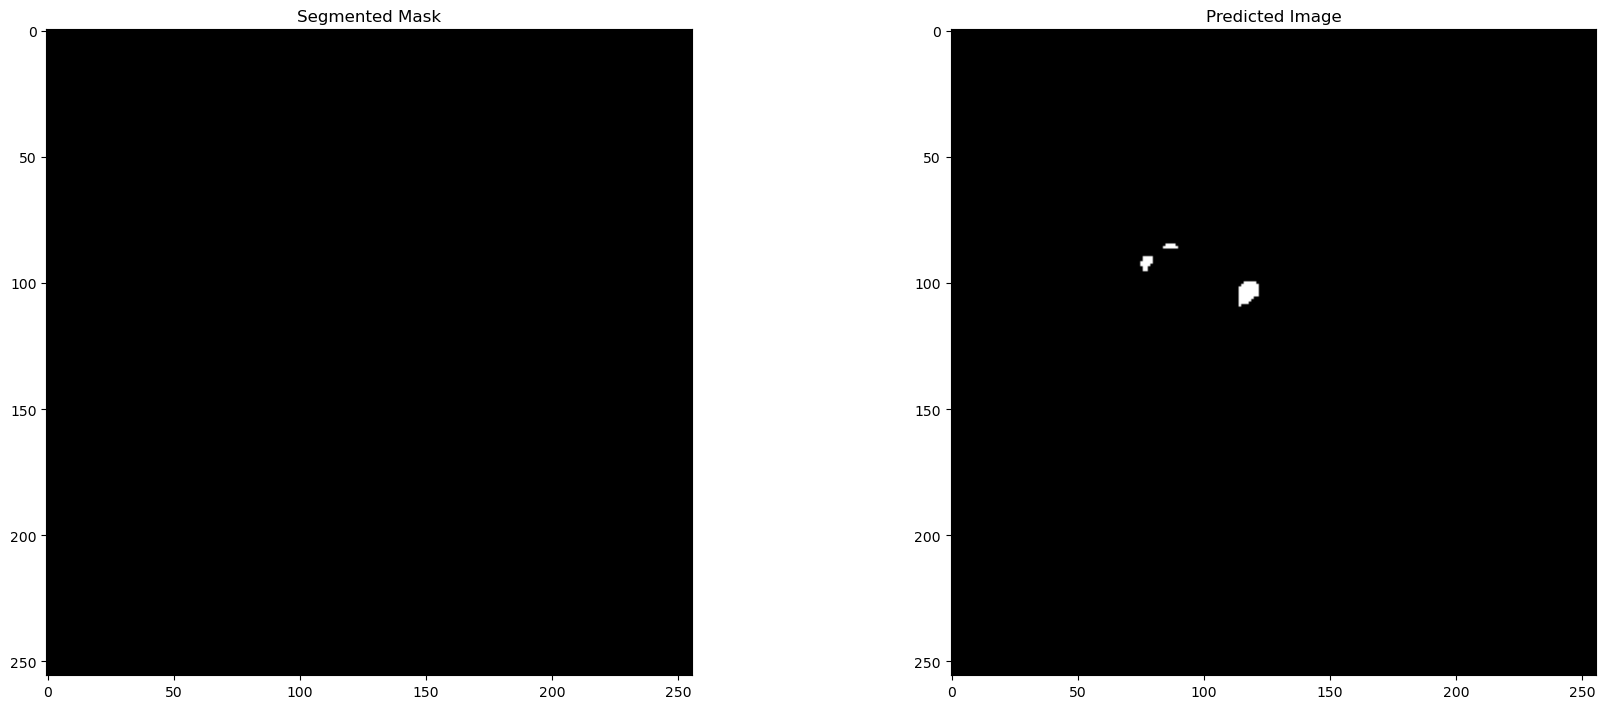

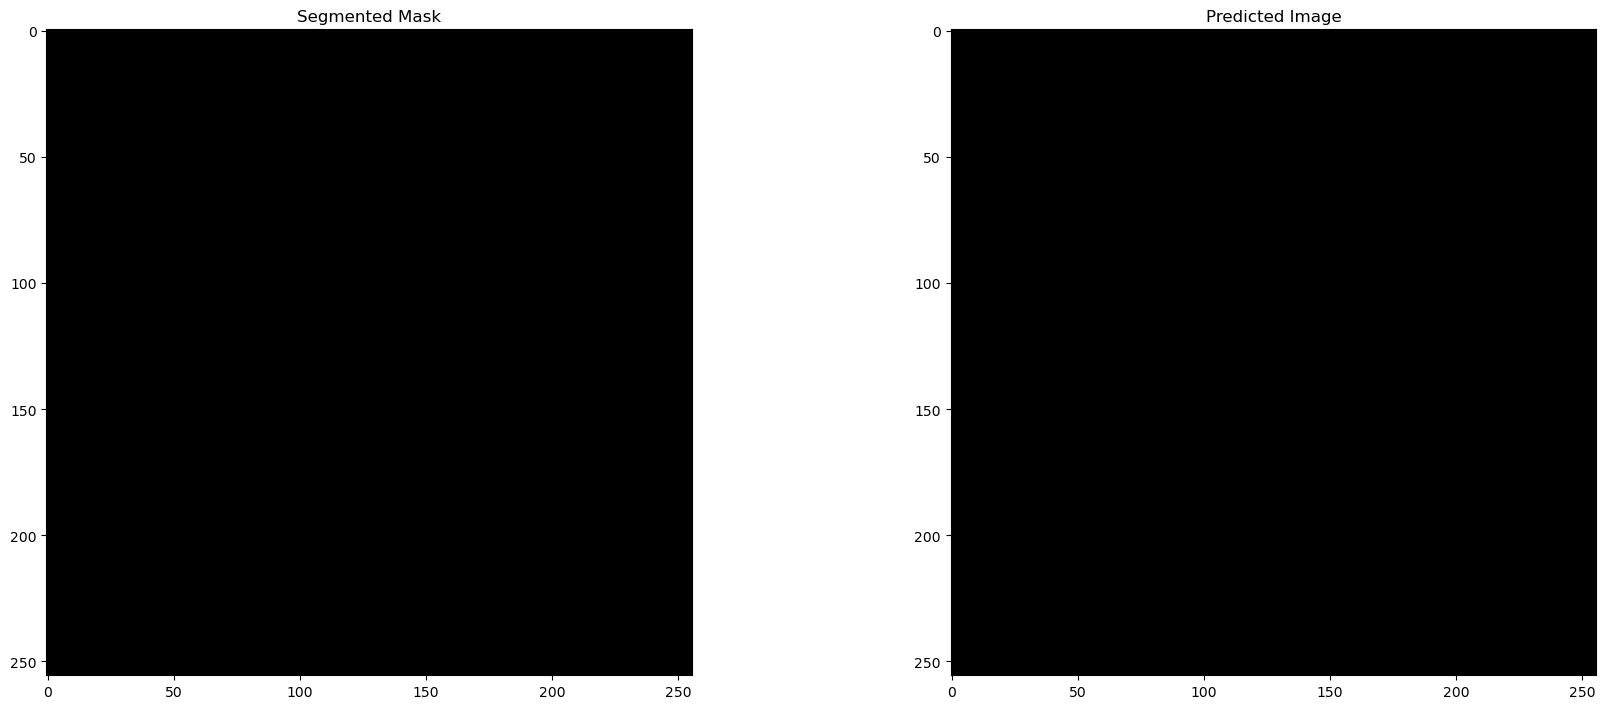

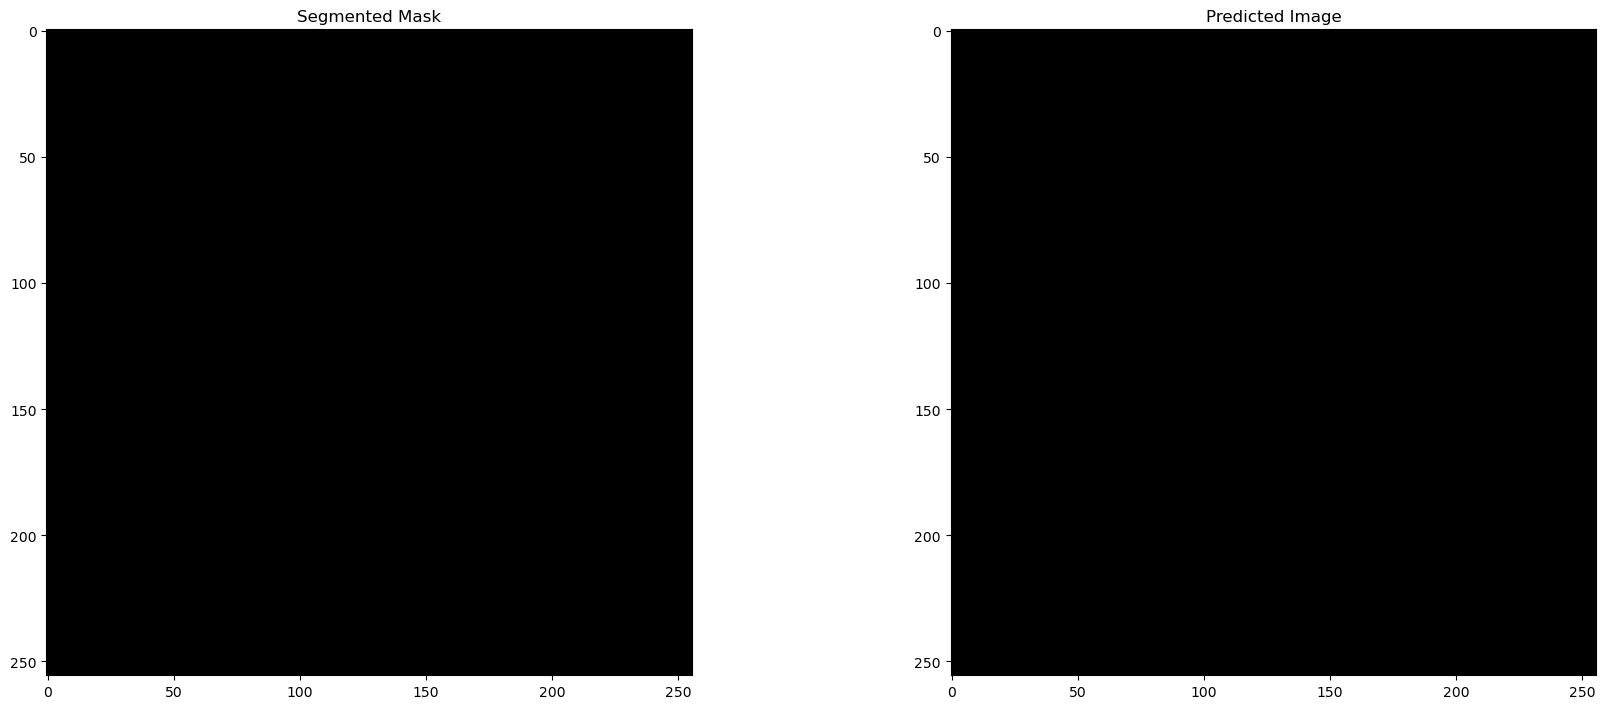

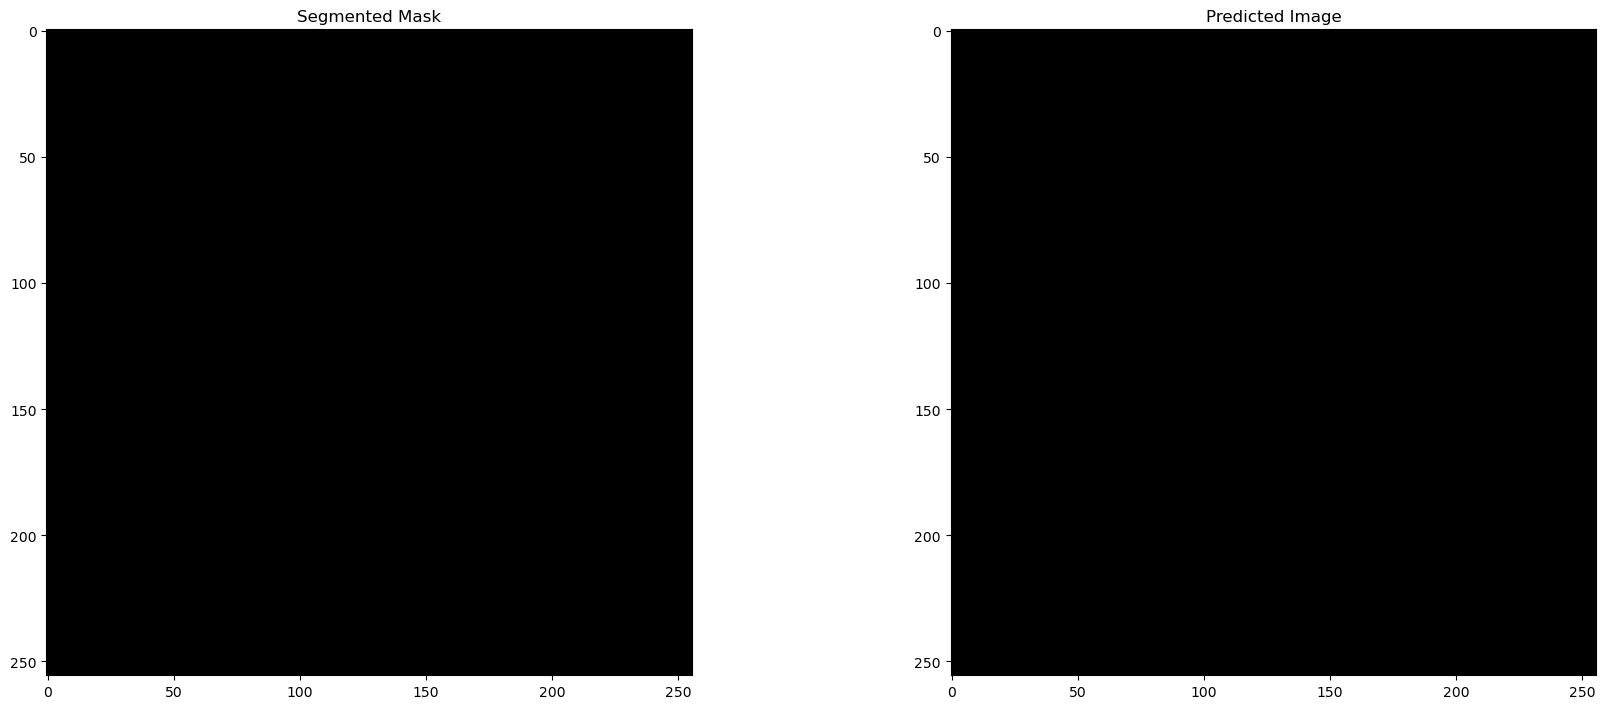

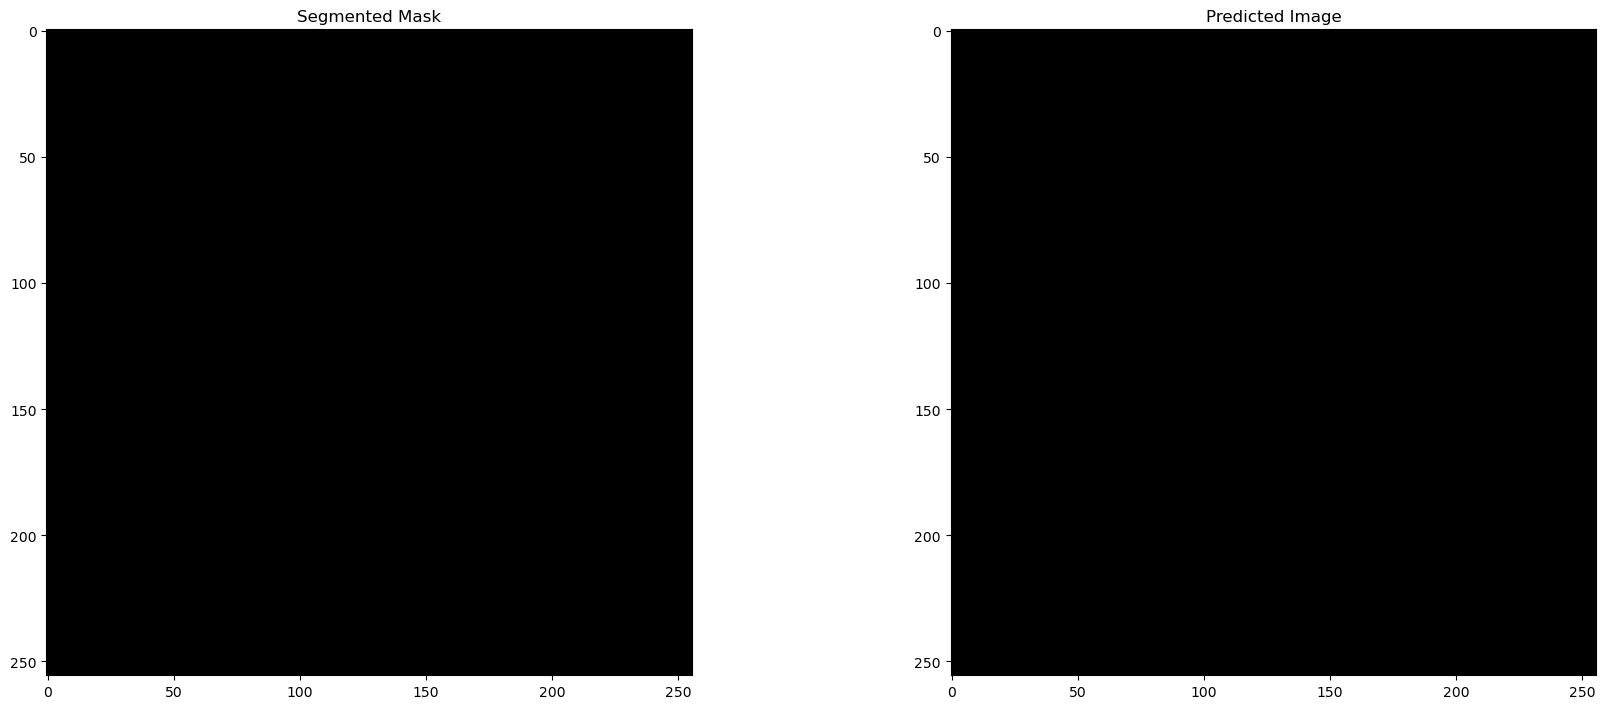

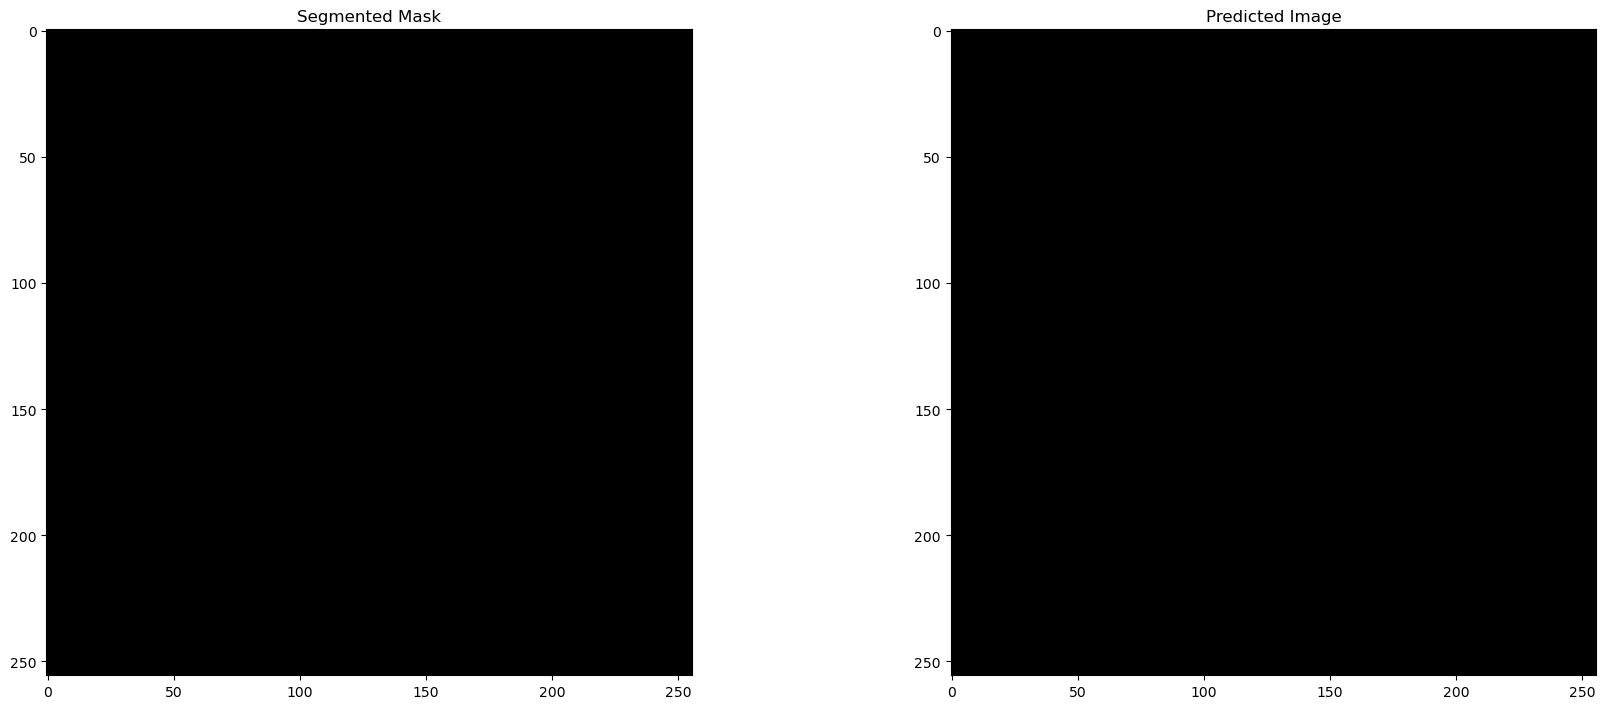

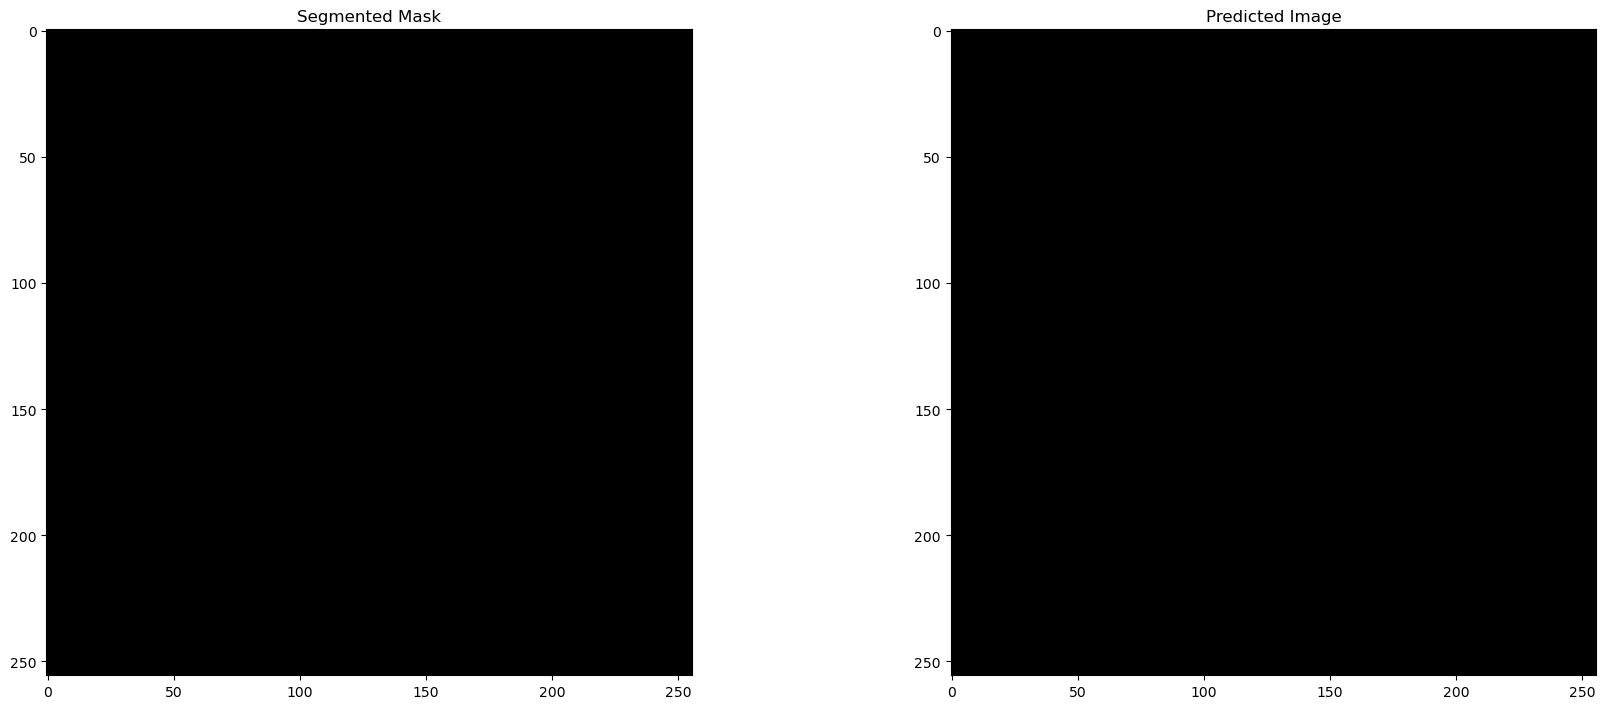

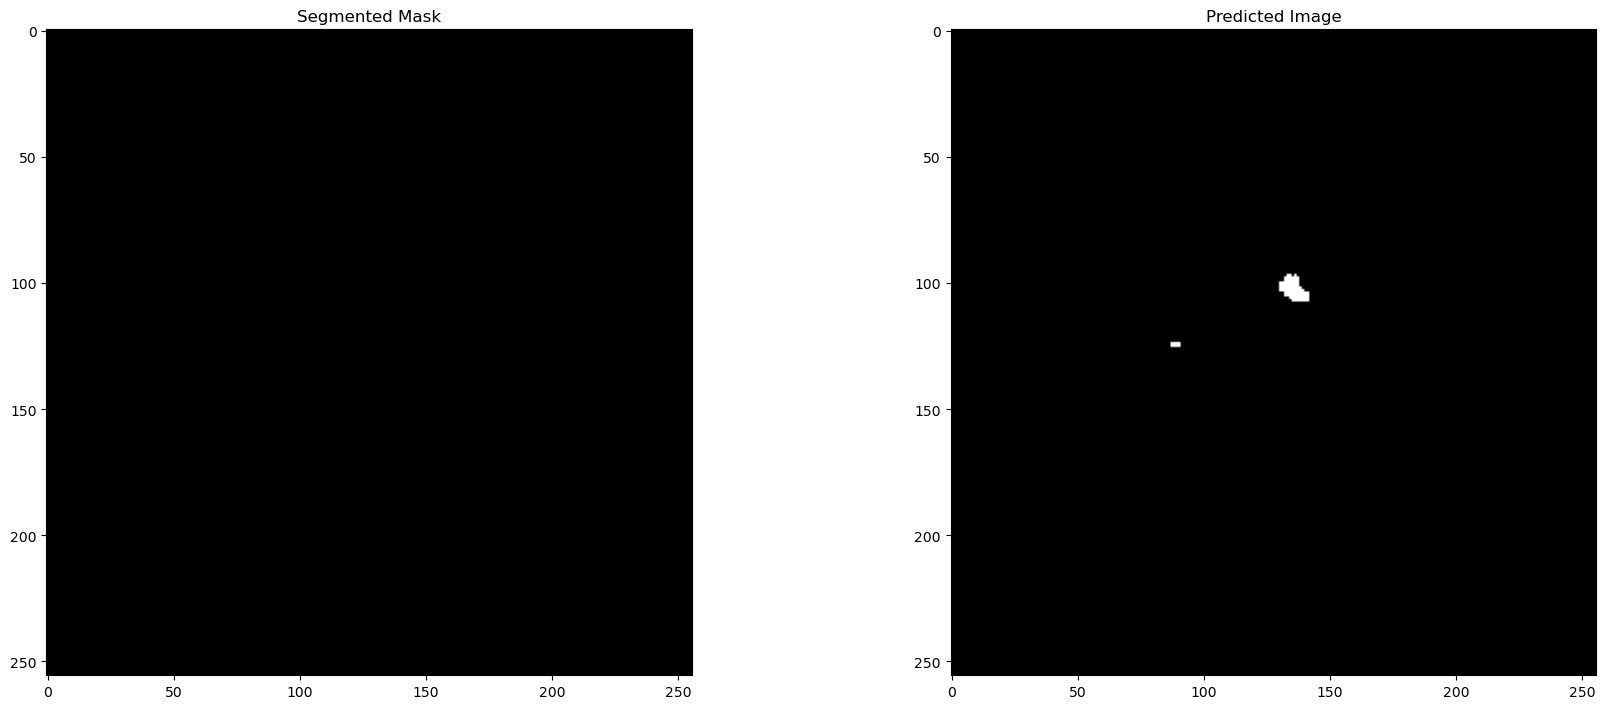

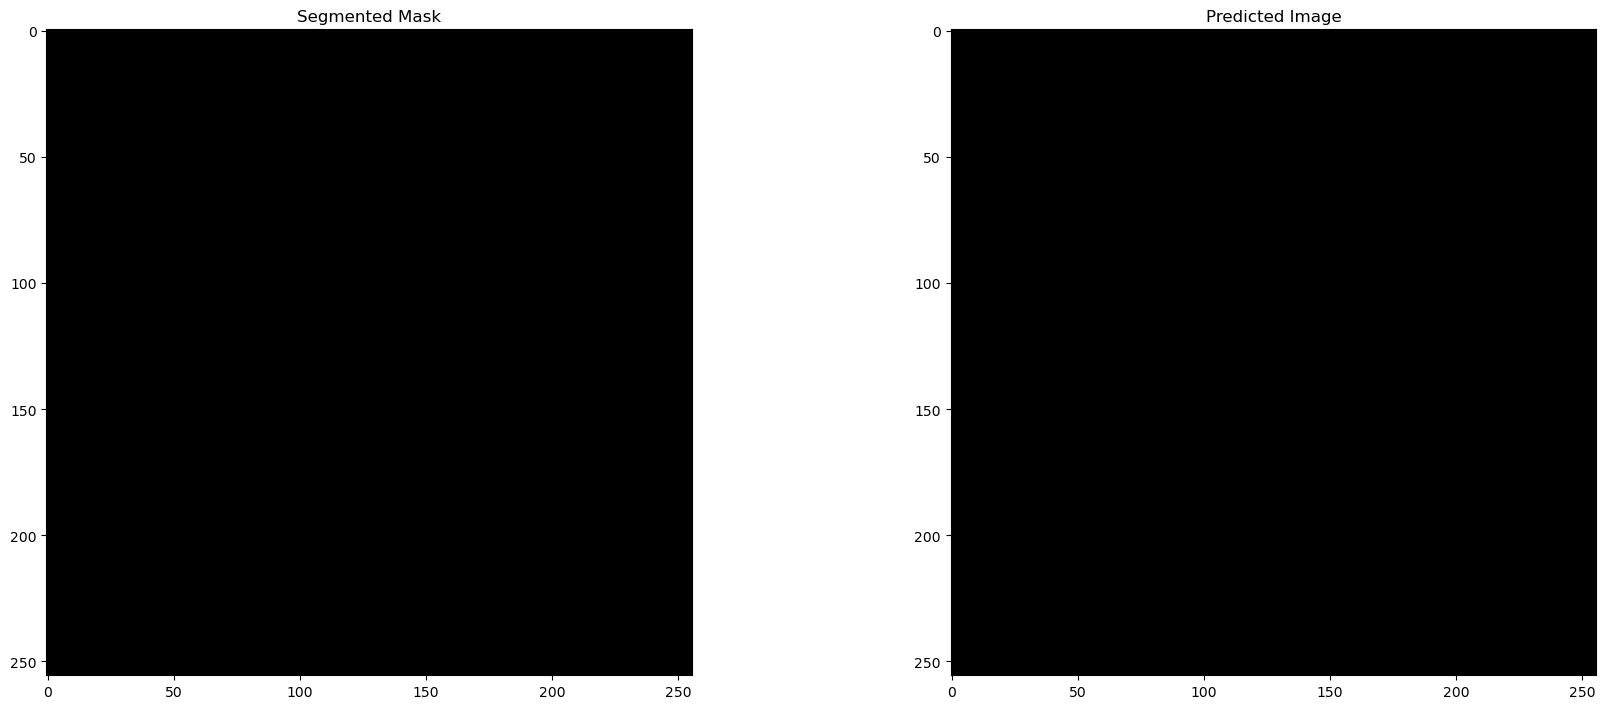

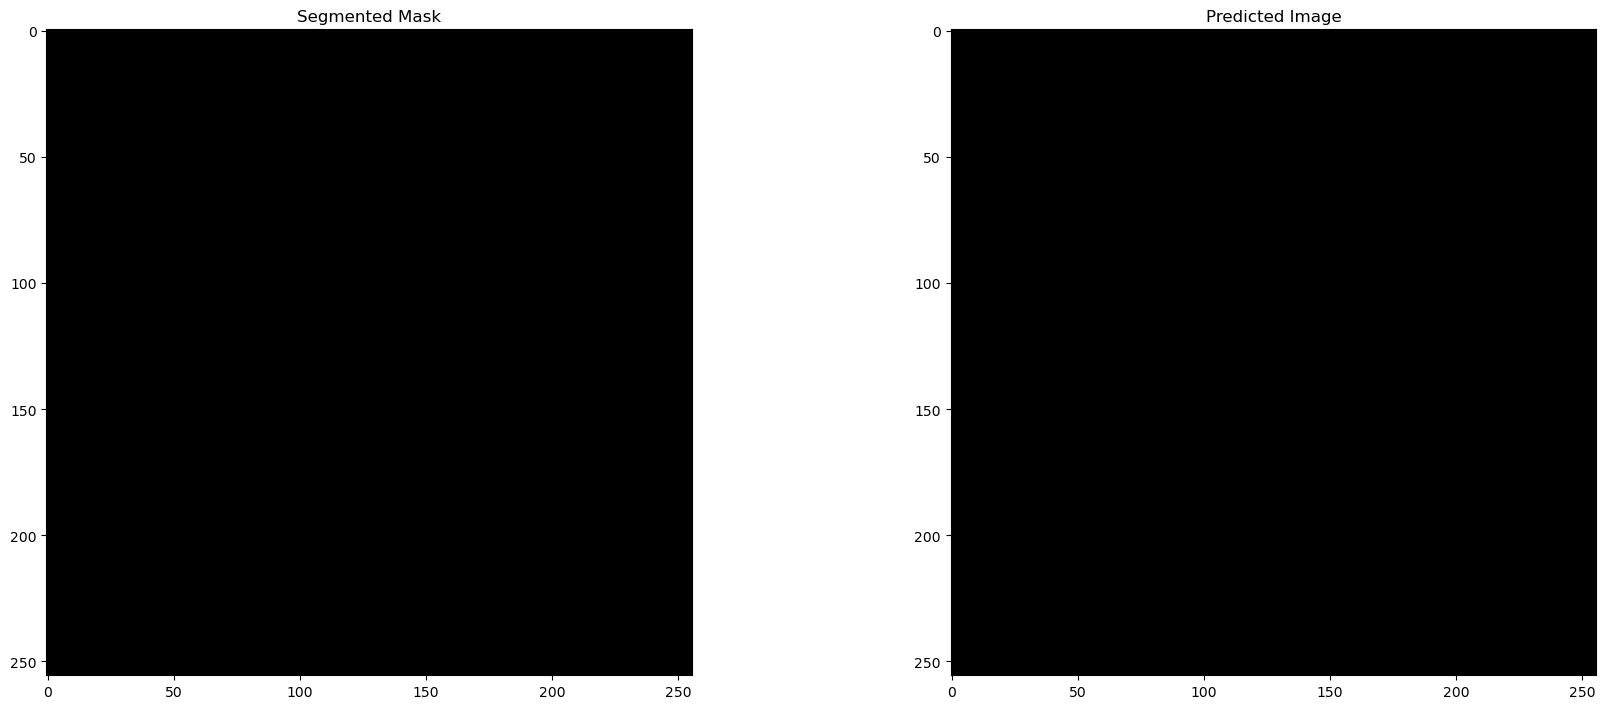

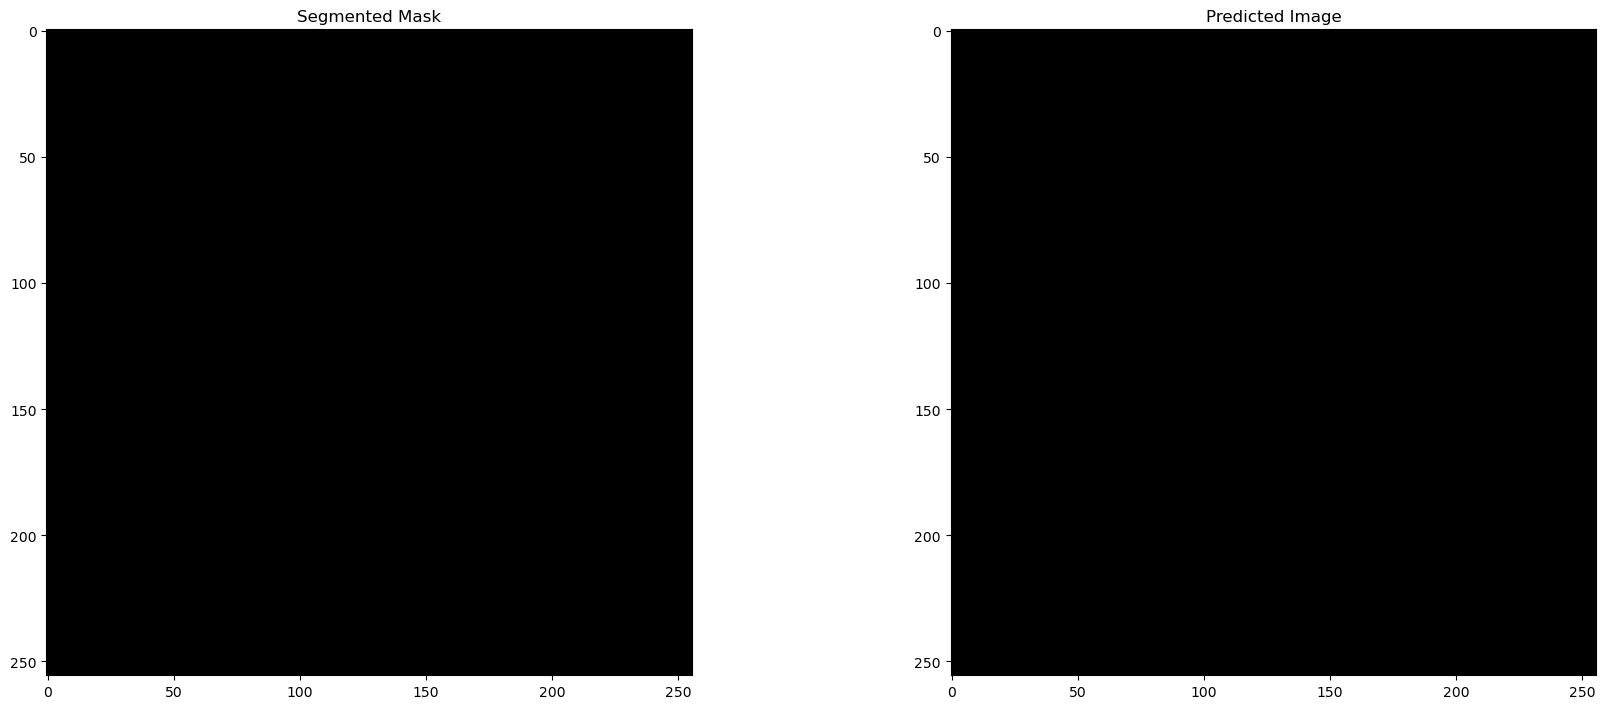

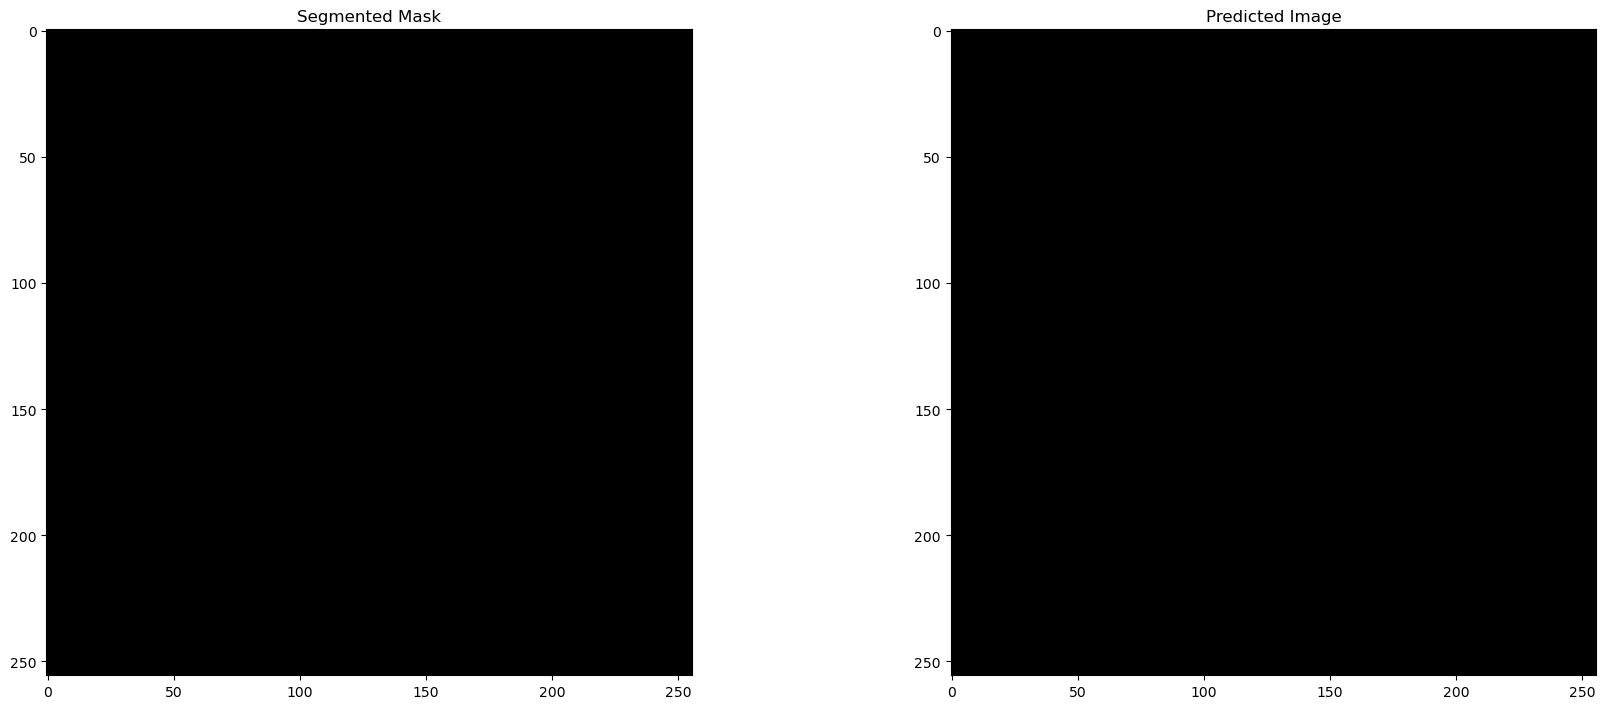

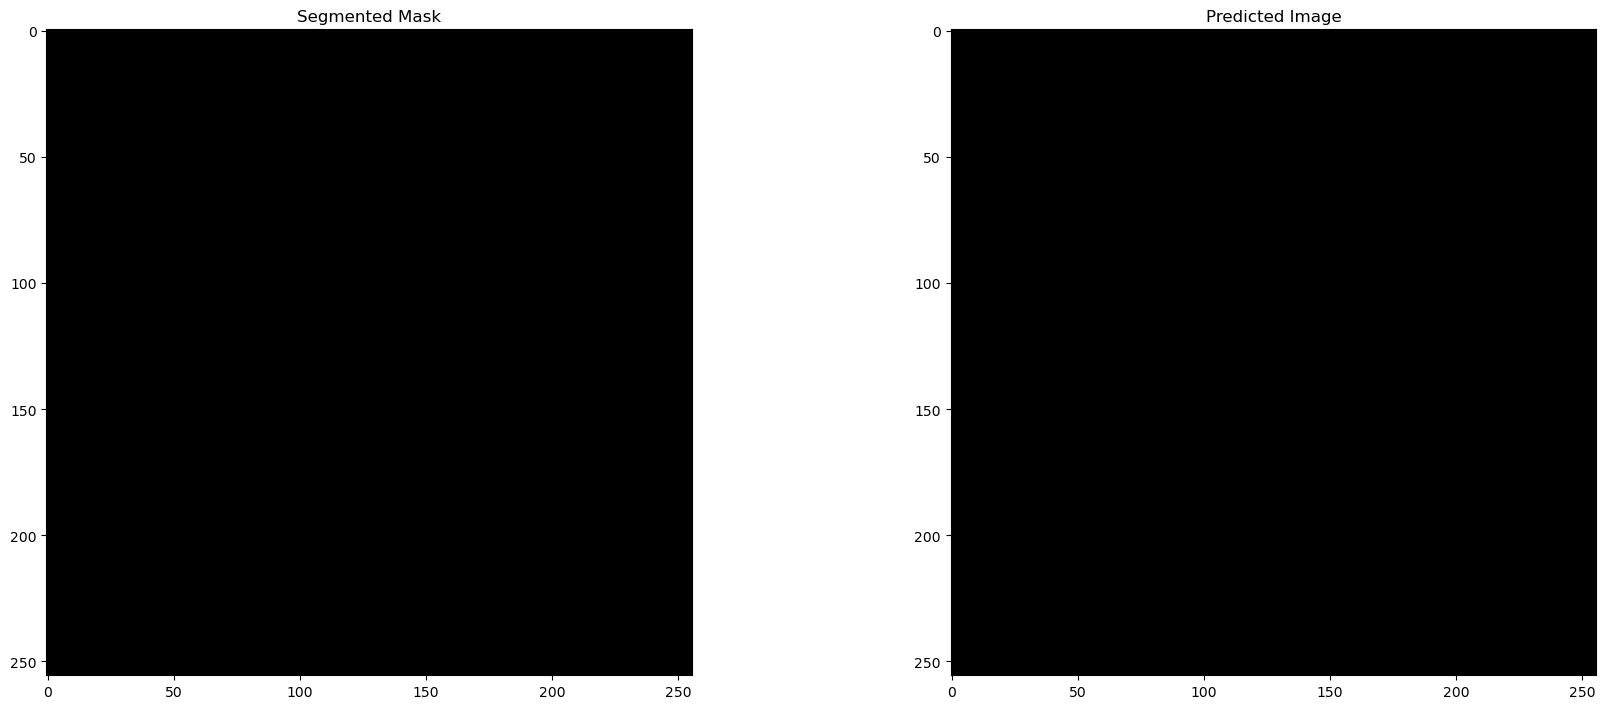

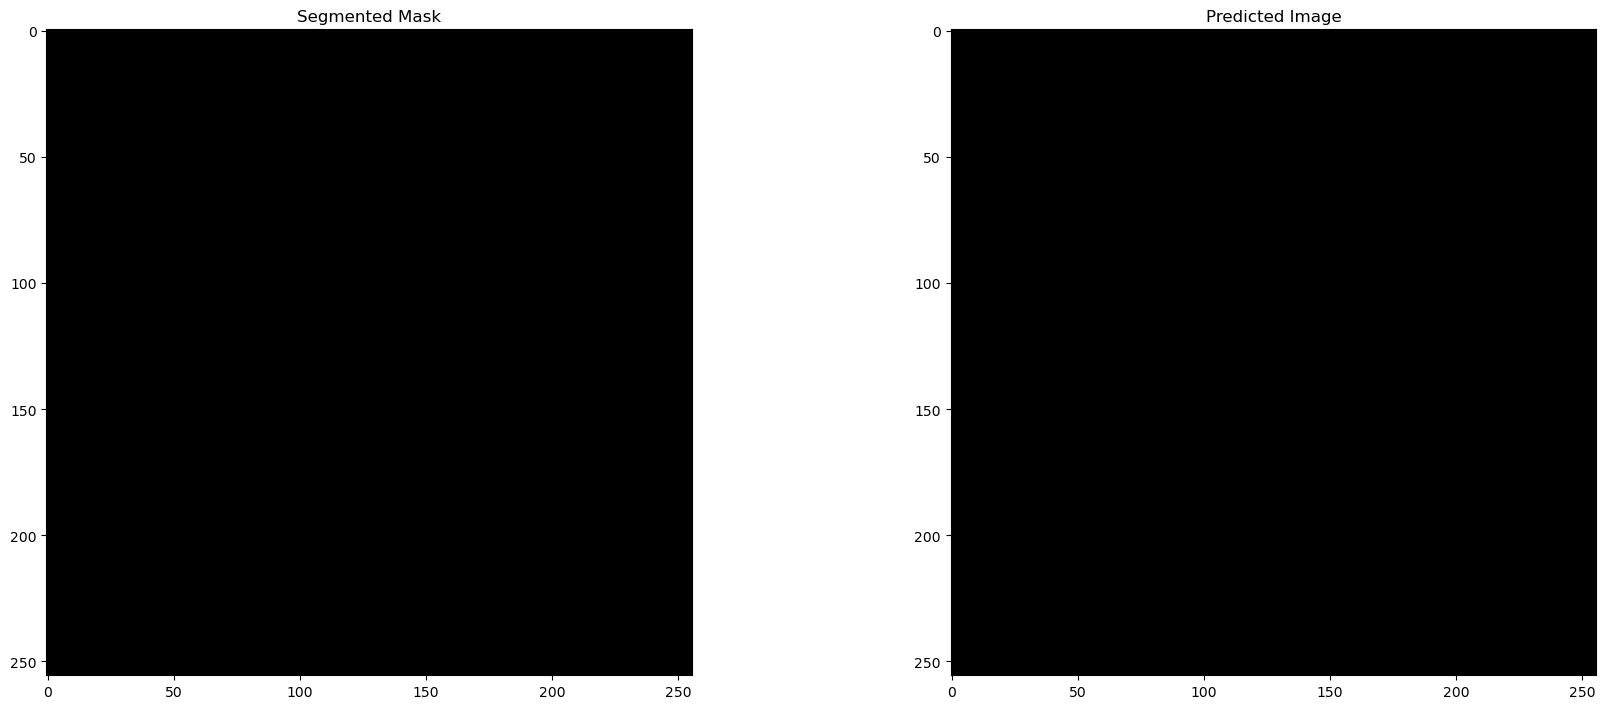

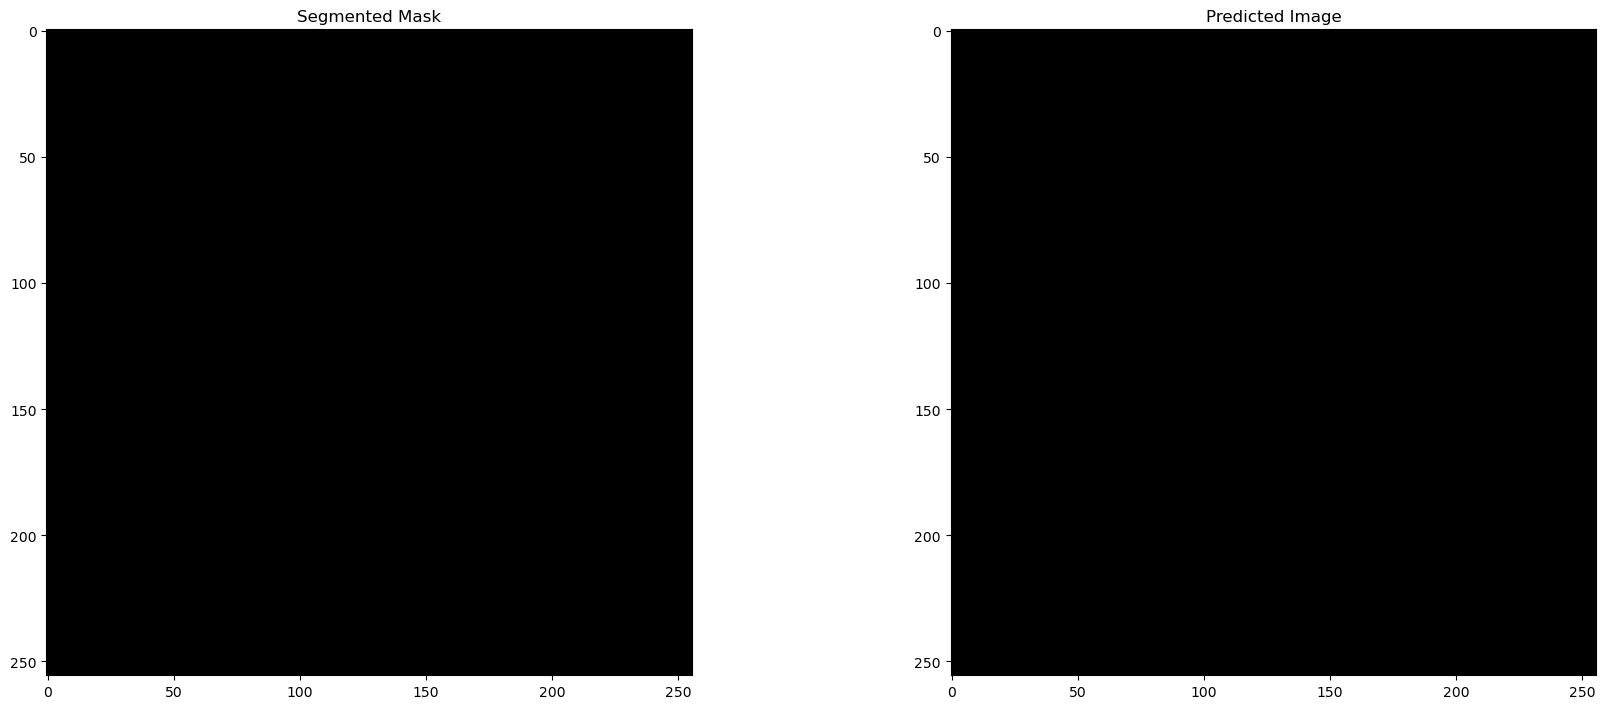

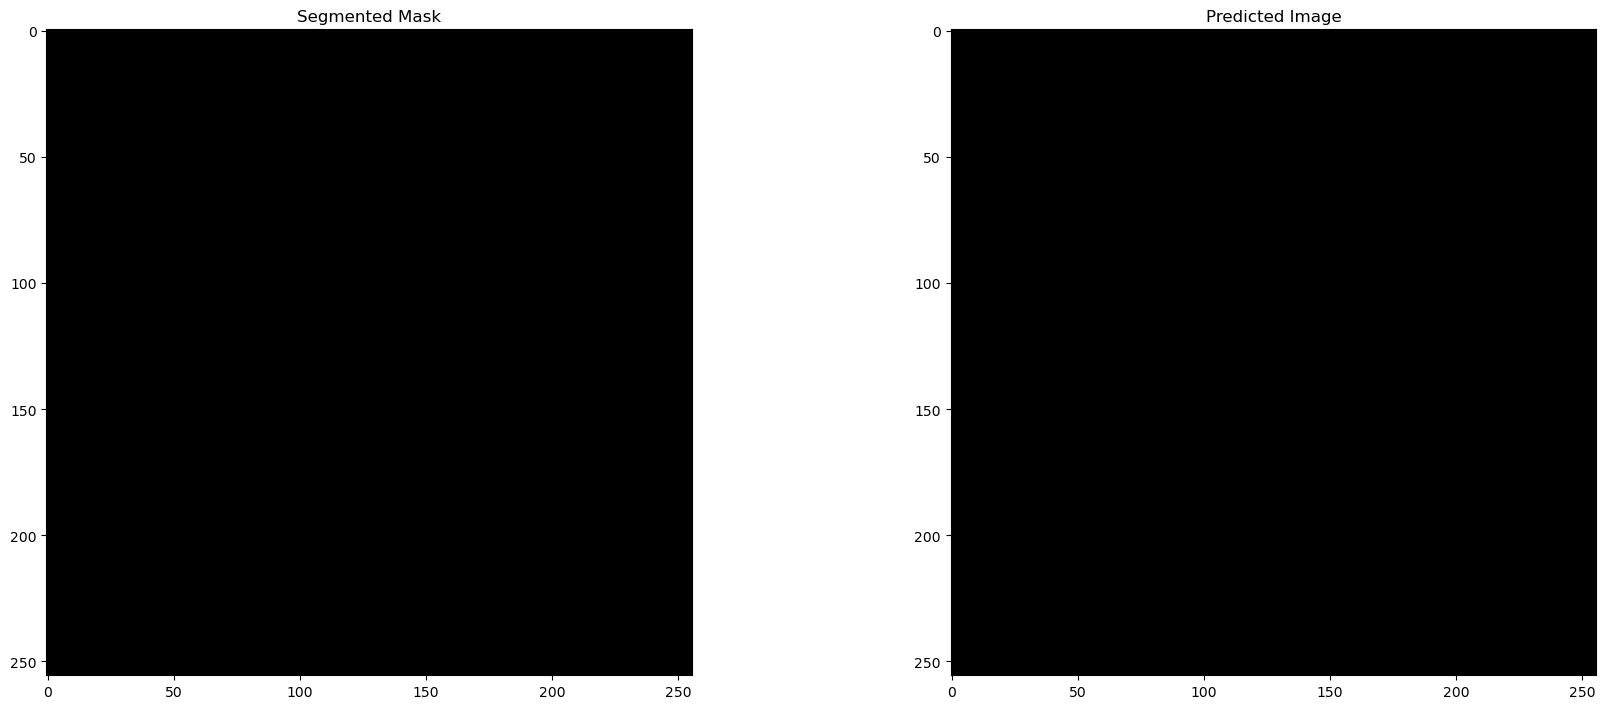

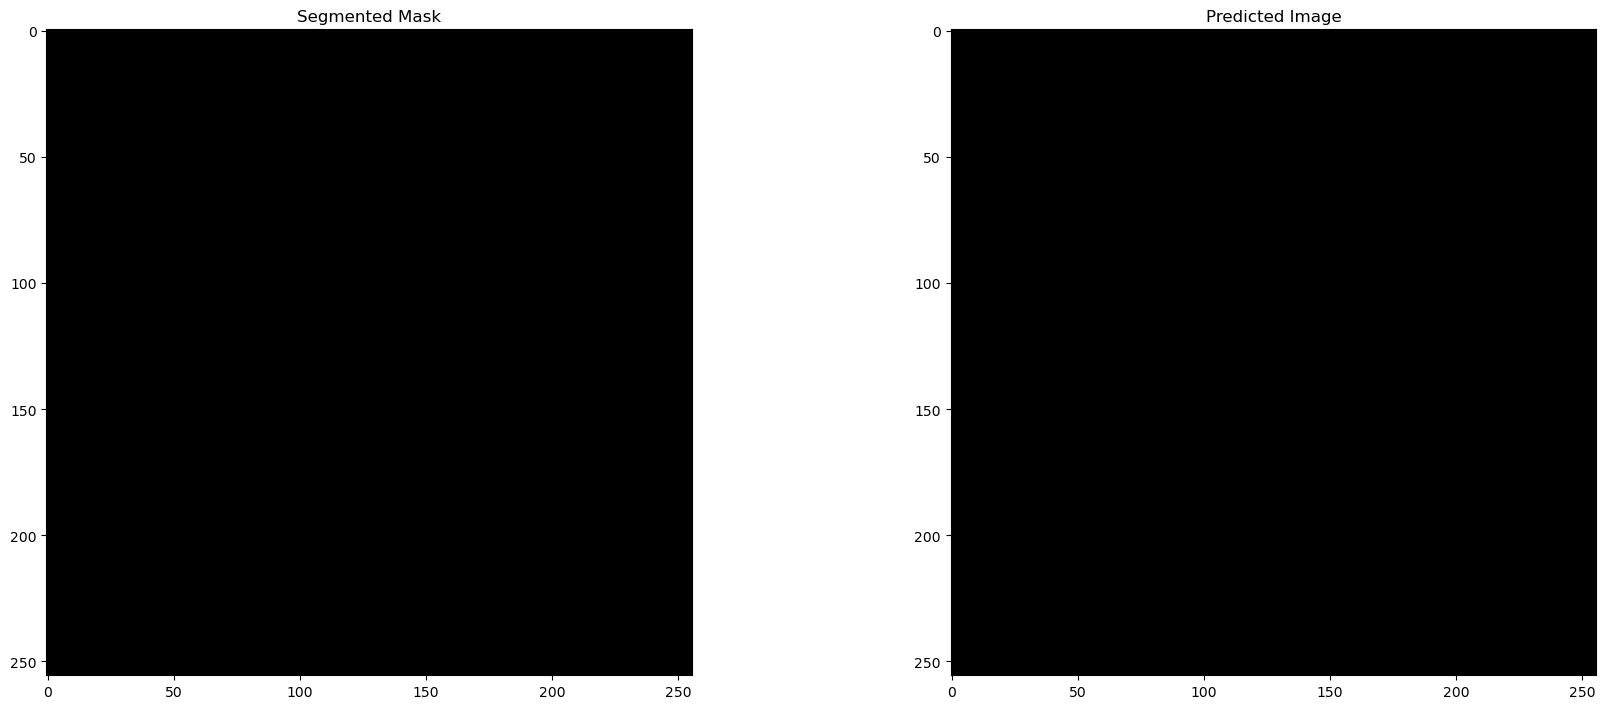

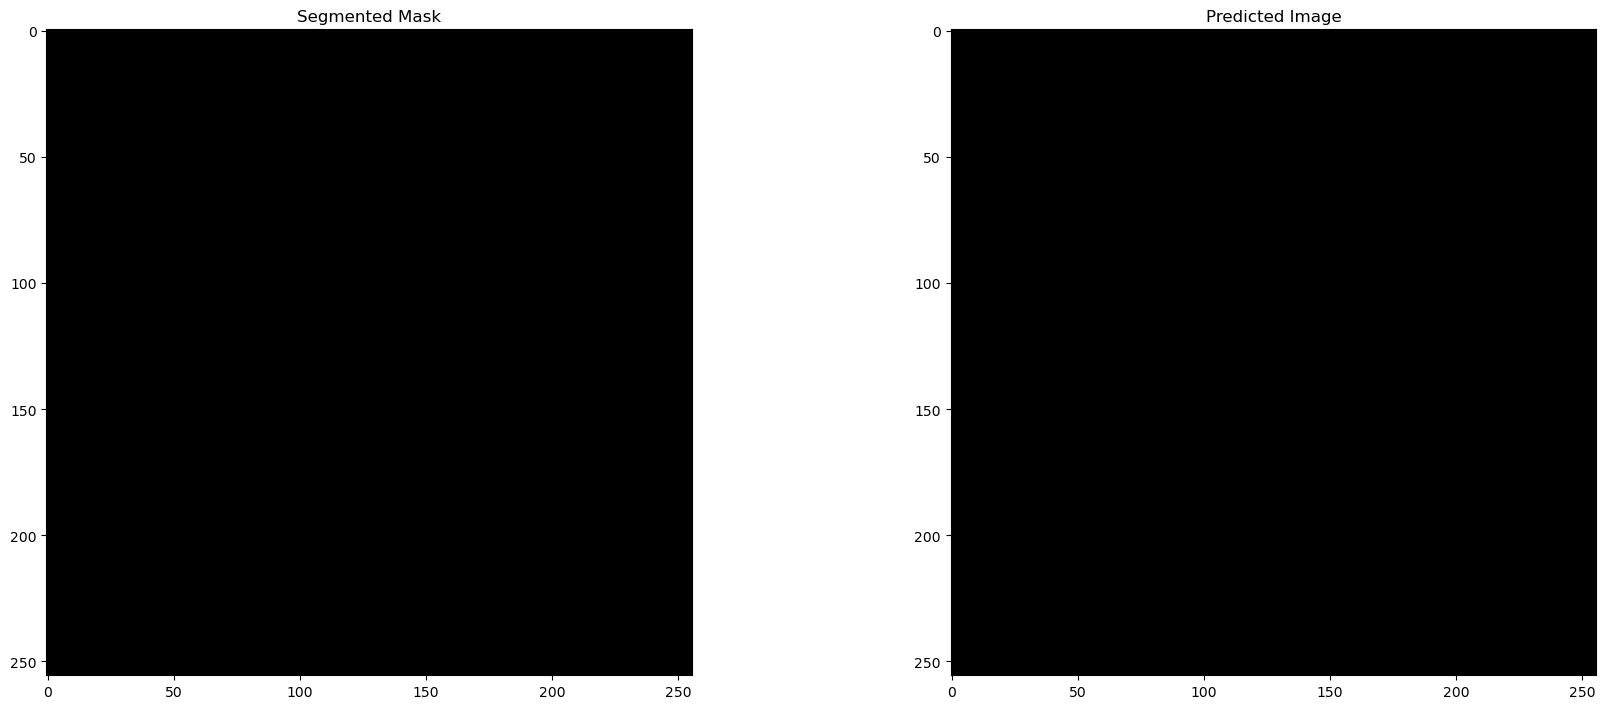

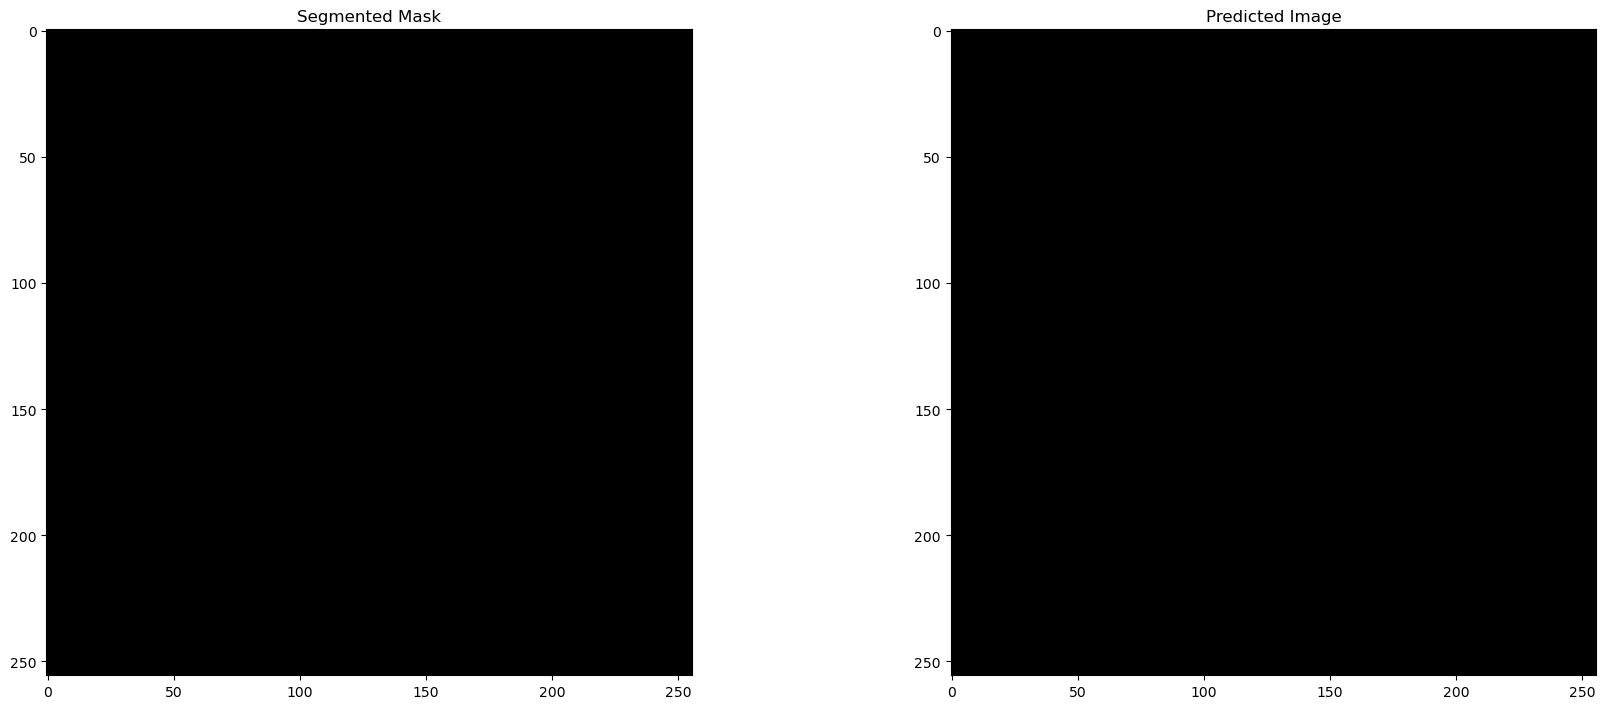

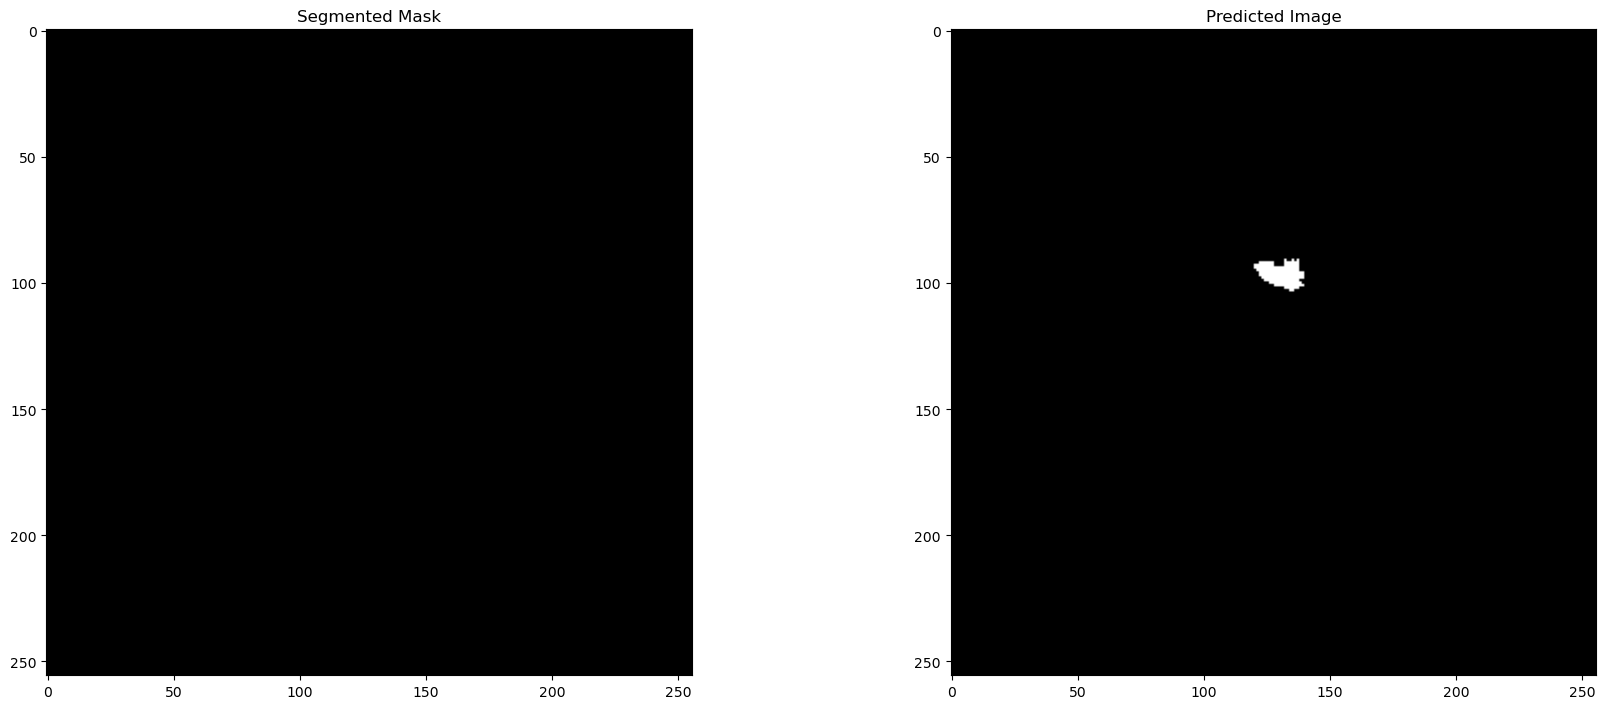

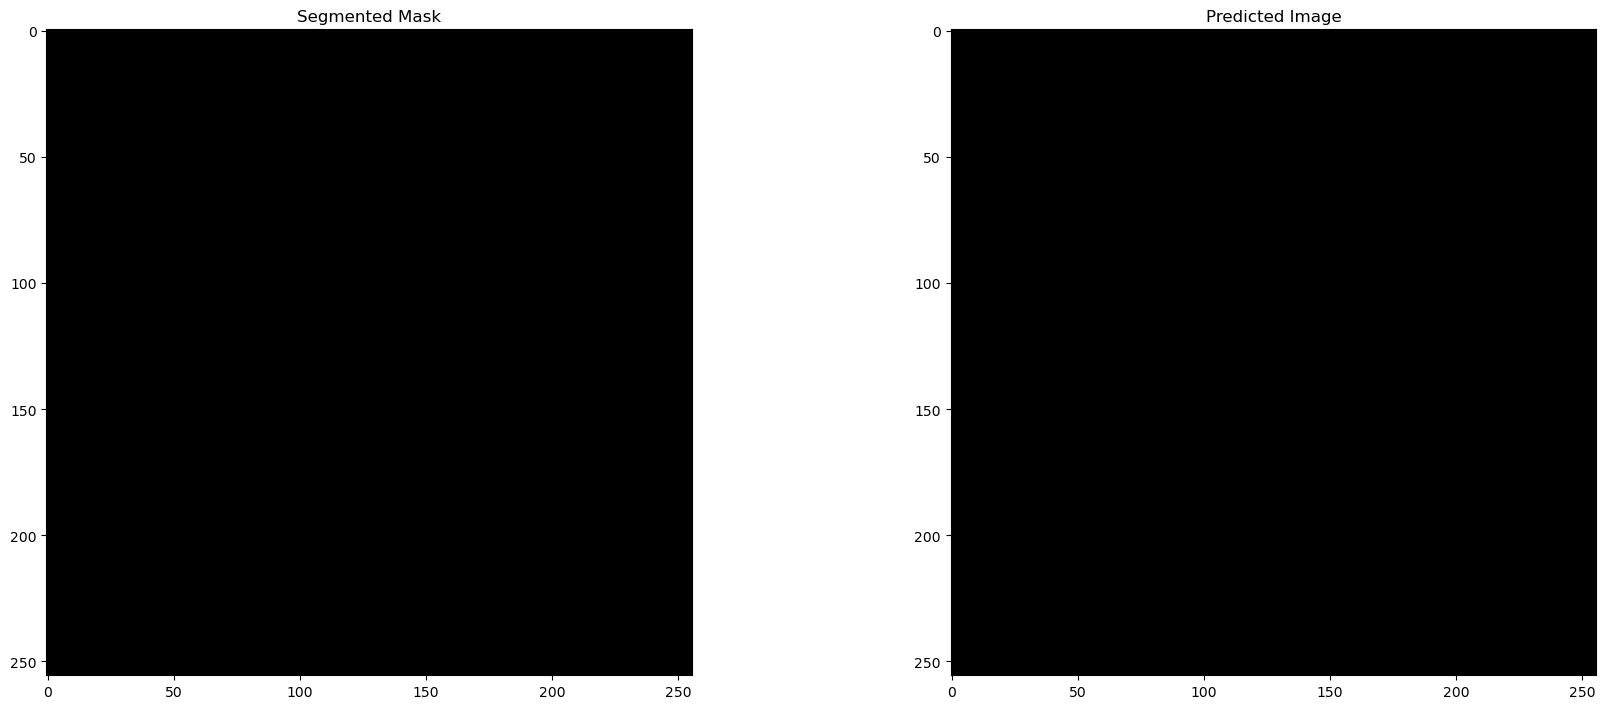

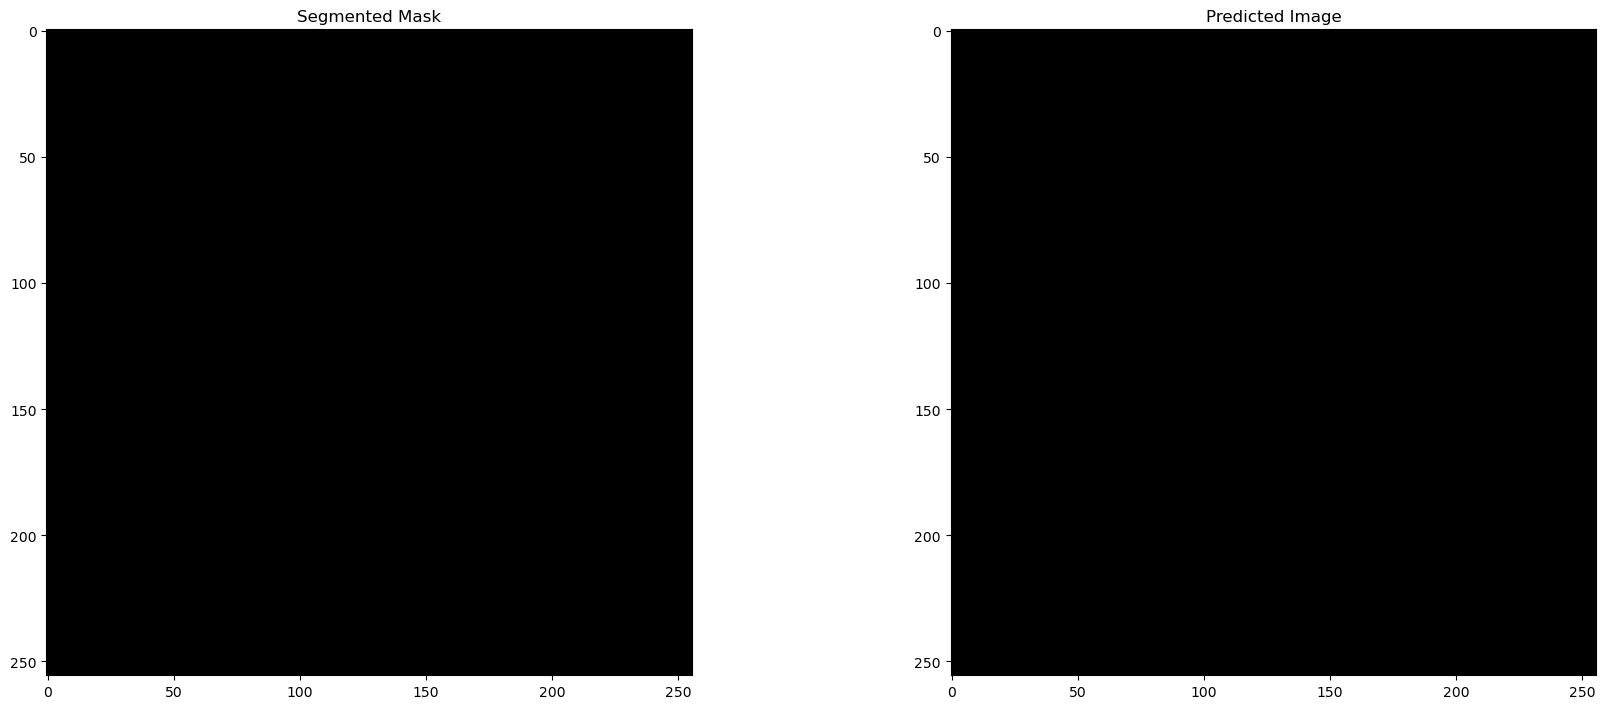

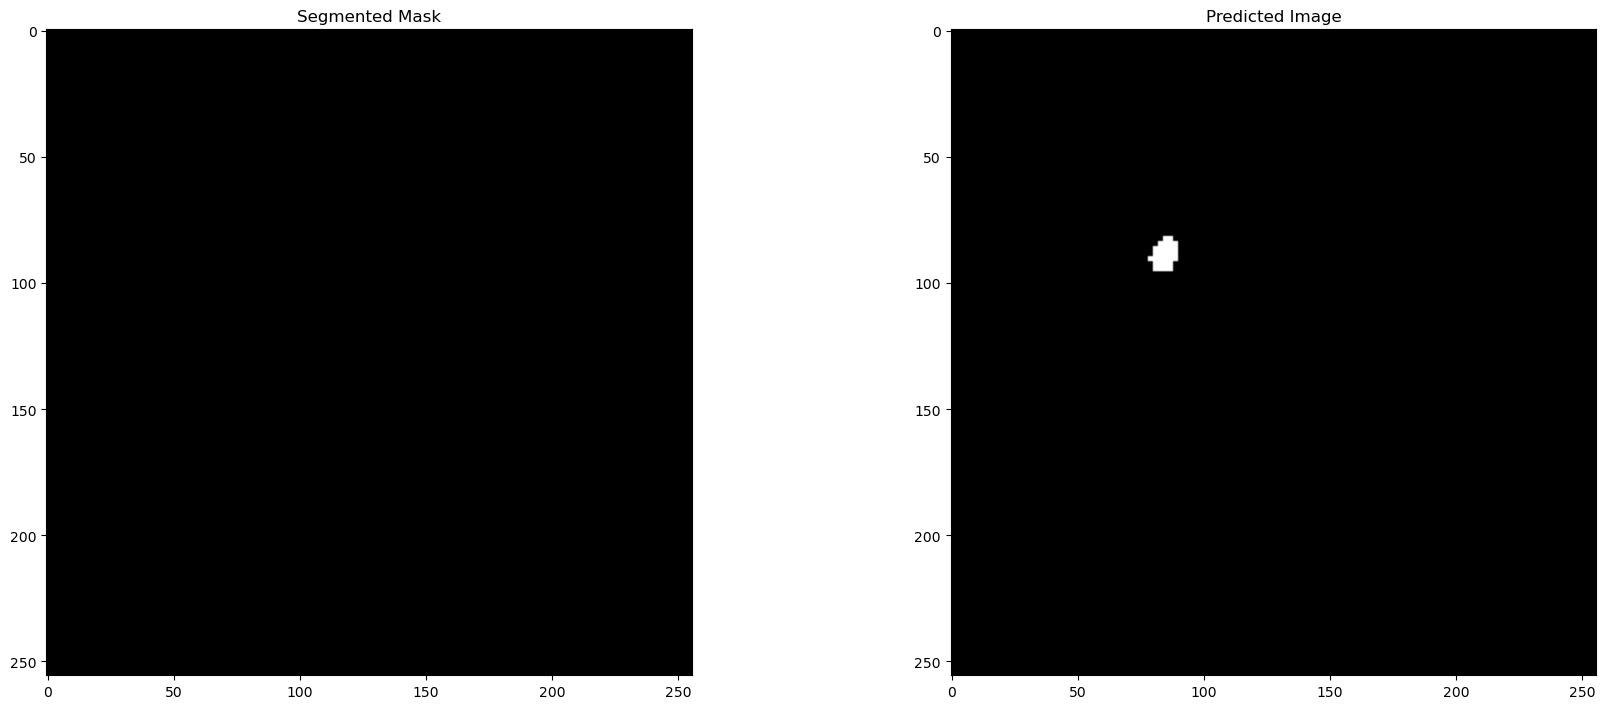

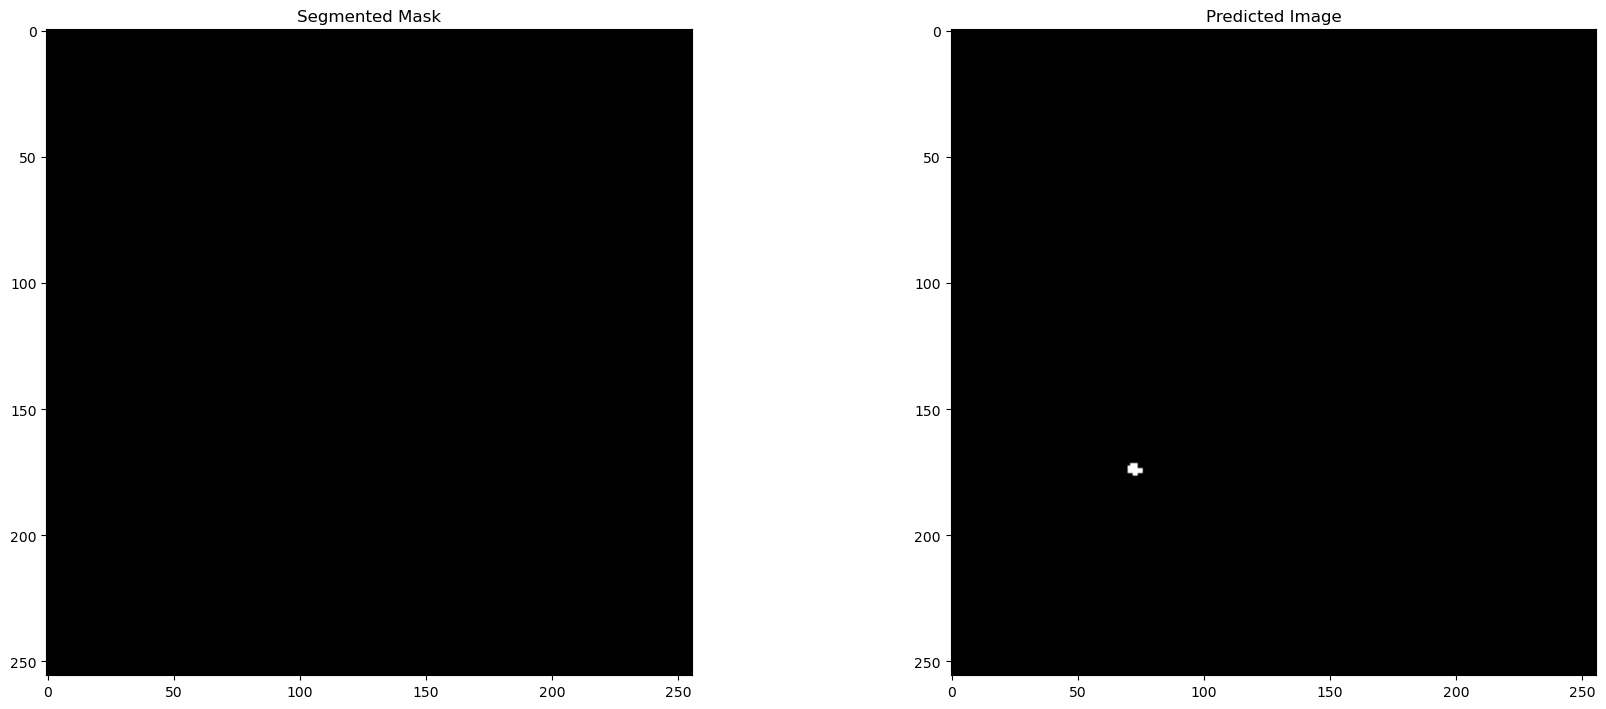

In [274]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Segmented Mask")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Predicted Image")

4
2
1/1 [==============================] - 2s 2s/step


[[65536]]
[65536]


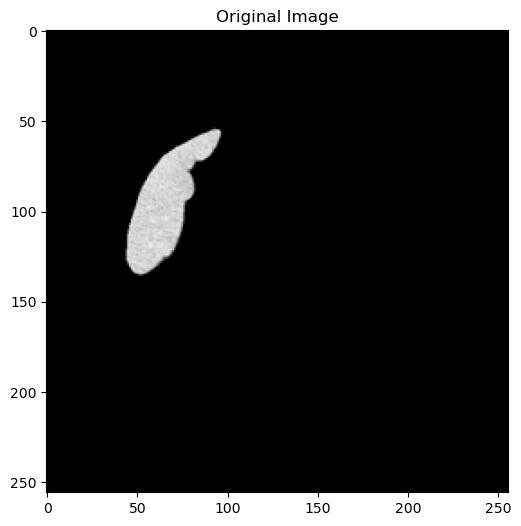

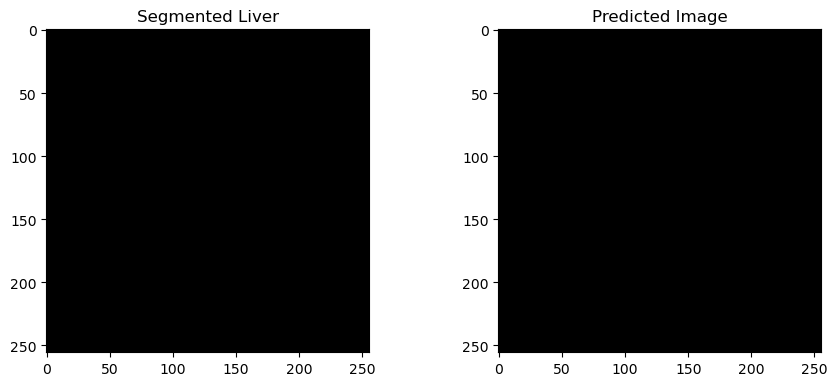

In [275]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(10)
result =  model.predict(x)
result = result > 0.9

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])
ax2.set_title("Original Image")

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
ax.set_title("Segmented Liver")
# ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)))
ax.set_title("Predicted Image")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [276]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str((2*(cm[3])/(2*cm[3]+cm[2]+cm[1])*100))+'%' )
# print("Dice Coefficient " + str(dice(y[2], result[2])))


IndexError: index 3 is out of bounds for axis 0 with size 1

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (2).

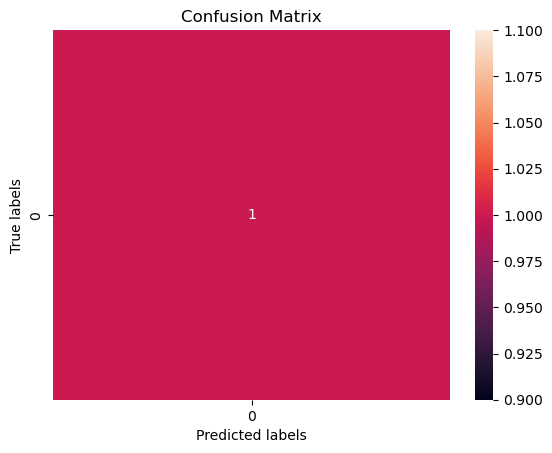

In [277]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

# print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);



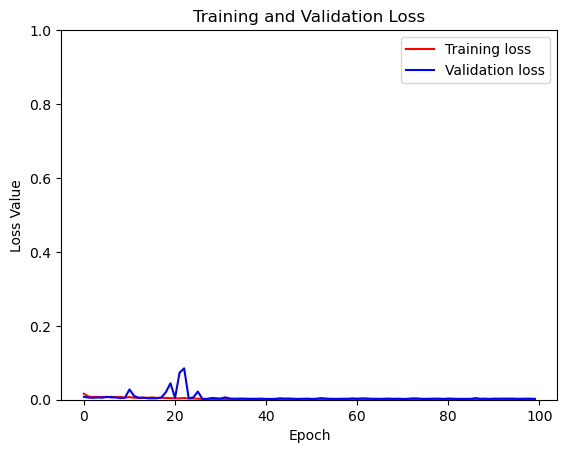

In [278]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

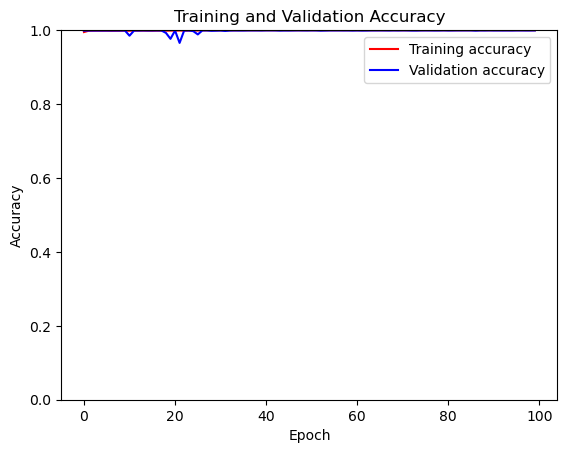

In [279]:
# Access training and validation accuracy values from the 'history' attribute
accuracy = model_history.history['acc']
val_accuracy = model_history.history['val_acc']

plt.figure()
plt.plot(range(len(accuracy)), accuracy, 'r', label='Training accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()
